# Overview

**[Predicting Heart Disease](https://www.kaggle.com/competitions/playground-series-s6e2/overview)**

Target은 Heart Disease

Learning Type: Binary Classification

Metric: Area under curve

In [1]:
import os
from pathlib import Path

In [2]:
data_path = Path('data')

if not os.path.exists(data_path / 'train.csv'):
    !kaggle competitions download -c playground-series-s6e2
    !unzip playground-series-s6e2.zip -d data
    !rm playground-series-s6e2.zip

In [3]:
import mllabs
mllabs.__version__

'0.3.0'

In [4]:
import polars as pl
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline

from mllabs import Experimenter, Connector
from mllabs.processor import PolarsLoader, PandasConverter
from mllabs.processor import CatConverter
from mllabs.collector import MetricCollector, ModelAttrCollector

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from IPython.display import Markdown

In [5]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from lightgbm import early_stopping as lgb_early_stopping
from sklearn.linear_model import LogisticRegression
from mllabs.adapter import XGBoostAdapter, LightGBMAdapter, CatBoostAdapter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from mllabs.col import ohe_drop_first
from mllabs.processor import FrequencyEncoder, CatPairCombiner
from sklearn.preprocessing import PolynomialFeatures

In [6]:
loader = make_pipeline(
    PolarsLoader(predefined_types={'id': pl.Int64}),
    PandasConverter(index_col='id')
)
train_file = data_path / 'train.csv'
test_file = data_path / 'test.csv'
df_train = loader.fit_transform([train_file])
df_data_spec = loader[0].df_type_.join(
    pd.Series(loader[0].pl_type_, name = 'actual_dtype')
)
df_data_spec

,min,max,na,count,n_unique,dtype,f32,i32,i16,i8,actual_dtype
feature,,,,,,,,,,,
Age,29.0,77.0,0.0,630000.0,42.0,Int64,True,True,True,True,Int8
BP,94.0,200.0,0.0,630000.0,66.0,Int64,True,True,True,False,Int16
Chest pain type,1.0,4.0,0.0,630000.0,4.0,Int64,True,True,True,True,Int8
Cholesterol,126.0,564.0,0.0,630000.0,150.0,Int64,True,True,True,False,Int16
EKG results,0.0,2.0,0.0,630000.0,3.0,Int64,True,True,True,True,Int8
Exercise angina,0.0,1.0,0.0,630000.0,2.0,Int64,True,True,True,True,Int8
FBS over 120,0.0,1.0,0.0,630000.0,2.0,Int64,True,True,True,True,Int8
Heart Disease,NaN,NaN,0.0,630000.0,2.0,String,False,False,False,False,Categorical
Max HR,71.0,202.0,0.0,630000.0,93.0,Int64,True,True,True,False,Int16


# Data Spec.

원본 데이터셋을 기반으로 Competition 용으로 인공적으로 생성한 데이터인데,

이 문제에 접근한 시점에서 원본 데이터가 올라온 페이지가

사라져서 정확한 스펙을 알수가 없다.

데이터에 대한 지식이 없어 GPT를 활용해서 대략의 스펙 조사.

변수의 대략의 스펙을 뽑아 보자.

In [7]:
print(df_data_spec.loc[:, ['min', 'max', 'n_unique', 'actual_dtype']].to_markdown())

| feature                 |   min |      max |   n_unique | actual_dtype   |
|:------------------------|------:|---------:|-----------:|:---------------|
| Age                     |    29 |     77   |         42 | Int8           |
| BP                      |    94 |    200   |         66 | Int16          |
| Chest pain type         |     1 |      4   |          4 | Int8           |
| Cholesterol             |   126 |    564   |        150 | Int16          |
| EKG results             |     0 |      2   |          3 | Int8           |
| Exercise angina         |     0 |      1   |          2 | Int8           |
| FBS over 120            |     0 |      1   |          2 | Int8           |
| Heart Disease           |   nan |    nan   |          2 | Categorical    |
| Max HR                  |    71 |    202   |         93 | Int16          |
| Number of vessels fluro |     0 |      3   |          4 | Int8           |
| ST depression           |     0 |      6.2 |         66 | Float32        |

## Type from GPT

| Feature                  | ML_Type      |
|--------------------------|-------------|
| Age                      | Numeric     |
| BP                       | Numeric     |
| Cholesterol              | Numeric     |
| Max HR                   | Numeric     |
| ST depression            | Numeric     |
| Chest pain type          | Categorical |
| EKG results              | Categorical |
| Exercise angina          | Categorical |
| FBS over 120             | Categorical |
| Sex                      | Categorical |
| Thallium                 | Categorical |
| Number of vessels fluro  | Ordinal     |
| Slope of ST              | Ordinal     |
| Heart Disease            | Target      |
| id                       | Identifier  |

**일단은 위 형식으로 따라가고, 타입 조정의 요소가 있을 때, 변경**

In [8]:
df_test = loader.transform([test_file])

Thallium 이 원소명이라 수치형으로 생각이 됐지만, GPT는 코드라고 응답했고,  범주형이라고 하여, 빈도 조사해 보자.

In [9]:
df_train['Thallium'].value_counts()

Thallium
3    372286
7    246748
6     10966
Name: count, dtype: int64

In [10]:
target = 'Heart Disease'
X_cont = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
X_nom = ['Chest pain type', 'EKG results', 'Thallium']
X_ord = ['Number of vessels fluro', 'Slope of ST']
X_bin = ['Exercise angina', 'FBS over 120', 'Sex']
X_all = X_cont + X_nom + X_ord + X_bin
print('Var. no', df_data_spec.shape[0])
print('Cont.', len(X_cont))
print('Nom.', len(X_nom))
print('Ord.', len(X_ord))
print('Bin.', len(X_bin))

Var. no 15
Cont. 5
Nom. 3
Ord. 2
Bin. 3


In [11]:
display(df_train.head(5))
df_train.shape

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


(630000, 14)

In [12]:
display(df_test.head(5))
df_test.shape

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
id,,,,,,,,,,,,,
630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


(270000, 13)

# 평가셋과 학습셋의 차이 파악

평가셋에 대한 정보가 딱히 없다. Train과 Test의 분포의 차이를 Train과 Test를 분류하는 모델을 만들어 살펴 보고,

피쳐의 특성을 파악할 때, Train과 Test의 분포 차이를 봐야 할 지를 정해 놓고, 속성별 파악을 하자.

In [12]:
df_is_test = pd.concat([
    df_train.drop(columns = [target]).assign(is_test=0),
    df_test.assign(is_test=1)
])
display(df_is_test.head())
df_is_test['is_test'].value_counts()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,is_test
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,0
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,0


is_test
0    630000
1    270000
Name: count, dtype: int64

In [13]:
if os.path.exists('exp/is_test'):
    e_is_test = Experimenter.load('exp/is_test', df_is_test)
    if e_is_test.status == 'closed':
        e_is_test.reopen_exp()
else:
    e_is_test = Experimenter.create(
        df_is_test, 'exp/is_test', title = 'Train/Test셋 여부를 구분', sp = StratifiedShuffleSplit(n_splits=1, random_state = 1), splitter_params = {'y': 'is_test'}
    )
Markdown(
    e_is_test.desc_spec()
)

📁 Created directory: exp/is_test


## Train/Test셋 여부를 구분

| 항목 | 값 |
|------|-----|
| **Outer Splitter (sp)** | `StratifiedShuffleSplit(n_splits=1, random_state=1)` |
| **Inner Splitter (sp_v)** | None |
| **Splitter Params** | `{y='is_test'}` |
| **Outer Folds** | 1 |
| **Inner Folds** | 1 |

In [14]:
import lightgbm as lgb
e_is_test.add_collector(
    MetricCollector(
        'AUC', Connector(edges = {'y': [(None, 'is_test')]}), slice(-1, None), roc_auc_score, include_train = True
    )
)
e_is_test.add_collector(
    ModelAttrCollector(
        'lgb_feature_importance', Connector(processor = lgb.LGBMClassifier), 'feature_importances'
    )
)
e_is_test.set_grp('clf', role = 'head', edges = {'y': [(None, 'is_test')]}, method = 'predict_proba')
e_is_test.set_node(
    'lgb1', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_all)]}, 
    params={'verbose': -1, 'categorical_features': X_nom}
)

Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0


{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f02ae2c14f0>}

In [15]:
e_is_test.exp()

Experimenting 1 node(s)
Exp 0/1 (0%) > Node 0/1 (0%)[lgb1] Exp error at fold 0: LightGBMError: categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name
Exp 1/1 (100%) lgb1 1/1 (100%)
Experimentation complete: 0/1 node(s), 1 error(s): ['lgb1']


[LightGBM] [Fatal] categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name


In [16]:
e_is_test.show_error_nodes()

[lgb1] LightGBMError: categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name


LGBMClassifier에 categorical_feature에 수치형 타입을 쓸 수 없으니, 범주형으로 변환하는 과정을 적용합니다.

In [17]:
e_is_test.set_grp('pre', role = 'stage', method = 'transform')

{'result': 'new',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f02ae2eff50>,
 'affected_nodes': []}

In [18]:
e_is_test.set_node(
    'n2c', grp='pre', processor=CatConverter, edges = {'X': [(None, X_nom)]}
)

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f02b1f09370>}

In [19]:
e_is_test.set_node(
    'lgb1', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'categorical_features': ['n2c__' + i for i in X_nom]}, method = 'predict_proba', exist = 'replace'
)

{'result': 'update',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f02ae2c14f0>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f02adadd3a0>}

In [20]:
Markdown(
    e_is_test.desc_pipeline()
)

```mermaid
graph TD

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph grp_clf["clf"]
        node_lgb1["lgb1"]
        style node_lgb1 fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_clf fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    subgraph grp_pre["pre"]
        node_n2c["n2c"]
        style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_pre fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    DataSource --> grp_clf
    DataSource --> grp_pre
    grp_pre --> grp_clf
```

In [21]:
Markdown(
    e_is_test.desc_node('lgb1', show_params=True)
)

```mermaid
graph TD

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph node_lgb1["clf/lgb1"]
        lgb1_info["<table><tr><td align='left'><b>processor</b></td><td align='left'>LGBMClassifier</td></tr><tr><td align='left'><b>method</b></td><td align='left'>predict_proba</td></tr><tr><td align='left'><b>verbose</b></td><td align='left'>-1</td></tr><tr><td align='left'><b>categorical_features</b></td><td align='left'>['n2c__Chest pain type', 'n2c__EKG re...</td></tr></table>"]
    end
    style node_lgb1 fill:#ffcdd2,stroke:#c62828,stroke-width:3px

    subgraph node_n2c["pre/n2c"]
        n2c_info["<table><tr><td align='left'><b>processor</b></td><td align='left'>CatConverter</td></tr><tr><td align='left'><b>method</b></td><td align='left'>transform</td></tr></table>"]
    end
    style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    DataSource -->|X,y| node_lgb1
    DataSource --> node_n2c
    node_n2c --> node_lgb1
```

**Path from DataSource to 'clf/lgb1' (2 path(s) found)**

### Edges

| Key | Node | Var |
|-----|------|-----|
| X | Data Source | `['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Exercise angina', 'FBS over 120', 'Sex']` |
| X | pre/n2c | * |
| y | Data Source | `is_test` |

In [22]:
e_is_test.build()

Building 1 node(s)
Build 1/1 (100%) n2c 1/1 (100%)
Build complete: 1 node(s)


In [23]:
e_is_test.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lgb1 1/1 (100%) 100/100 (100%)
Experimentation complete: 1 node(s)


In [24]:
e_is_test.get_obj_vars('lgb1', 0)

[(['Age',
   'BP',
   'Cholesterol',
   'Max HR',
   'ST depression',
   'Exercise angina',
   'FBS over 120',
   'Sex',
   'n2c__Chest pain type',
   'n2c__EKG results',
   'n2c__Thallium'],
  ['lgb1__is_test_0', 'lgb1__is_test_1'],
  [0])]

In [25]:
e_is_test.collectors['AUC'].get_metrics_agg(None)[0]

,valid,train_sub
lgb1,0.503313,0.542511


In [26]:
from mllabs import ColSelector

In [27]:
e_is_test.set_node(
    'lgb2', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'categorical_features': ColSelector(col_type = 'category'), 'n_estimators': 1000}, method = 'predict_proba'
)
e_is_test.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lgb2 1/1 (100%) 1000/1000 (100%)
Experimentation complete: 1 node(s)


In [28]:
e_is_test.pipeline.compare_nodes(
    e_is_test.pipeline.get_node_names('lgb*')
)['LGBMClassifier'].fillna('default').join(
    e_is_test.collectors['AUC'].get_metrics_agg(None)[0].stack().rename('AUC').to_frame().unstack()
)

params               \
                                   categorical_features n_estimators   
lgb1  [n2c__Chest pain type, n2c__EKG results, n2c__...      default   
lgb2  <mllabs._pipeline.ColSelector object at 0x7f02...       1000.0   

           AUC            
         valid train_sub  
lgb1  0.503313  0.542511  
lgb2  0.504157  0.638938

In [29]:
e_is_test.close_exp()

Finalize 'n2c'
Finalize 'lgb1'
Finalize 'lgb2'


입력 속성으로 LGBMClassifier로 Train과 Test를 구분하는 모델을 만든 결과

Train과 Test를 구분하기에는 어렵다는 것을 확인할 수 있었습니다.

따라서 Train과 Test의 입력 Feature의 차이점 분석은 유의미한 정보를 얻을 가능성은 적습니다.

우선 순위를 미루고, score상 Validation 결과와 차이가 크다면, 분석을 고려합니다.

여기서 LGBM에서의 feature importance는 의미는 없지만, 기능을 보이기 위해 참고적으로 출력합니다.

In [30]:
e_is_test.collectors['lgb_feature_importance'].get_attrs()['lgb2']

[[Age                     5085
  BP                      4413
  Cholesterol             6503
  Max HR                  5869
  ST depression           3974
  Exercise angina          701
  FBS over 120             366
  Sex                      678
  n2c__Chest pain type     546
  n2c__EKG results         940
  n2c__Thallium            925
  Name: importance, dtype: int32]]

# Exploratory Data Analysis

## Target: Heart Disease

In [31]:
df_train[target].value_counts().pipe(
    lambda x: pd.concat([x, (x / x.sum()).rename('ratio')], axis=1)
)

,count,ratio
Heart Disease,,
Absence,347546,0.55166
Presence,282454,0.44834


Absence(55.2%) vs Presence(44.8%)로 약한 불균형. Stratified split으로 대응 가능하며 별도의 imbalance 처리는 우선 불필요.

## Continuous Variable

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
X_cont

['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

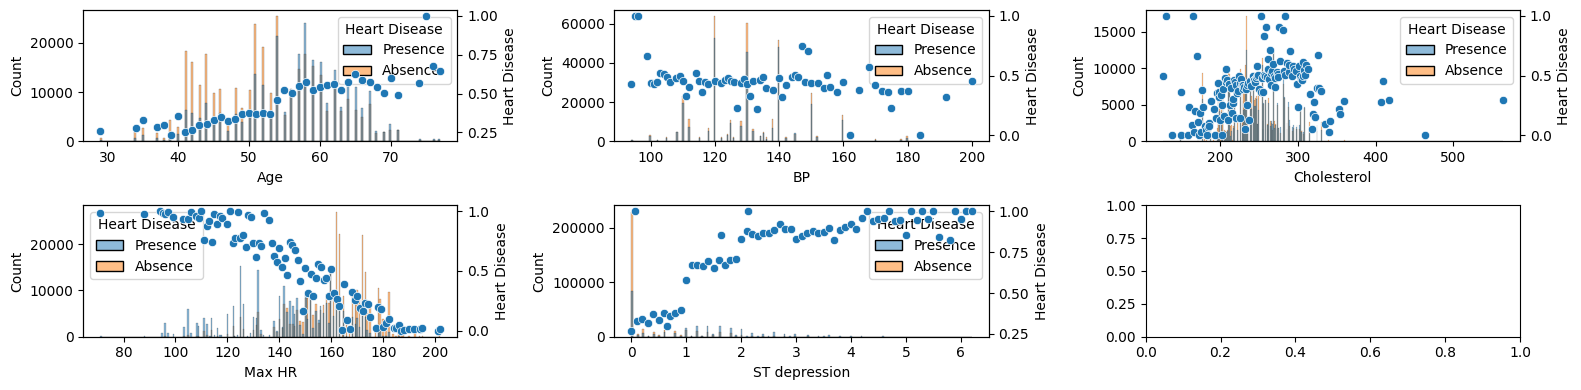

In [58]:
_, axes = plt.subplots(2, 3, figsize = (16, 4))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train, x = i, ax = ax, hue = target)
    df_train.groupby(i)[target].agg(lambda x: (x == 'Presence').mean()).to_frame().pipe(
        lambda x: sns.scatterplot(x, x = i, y = target, ax = ax.twinx())
    )
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score

df_train[X_cont].apply(
    lambda x: roc_auc_score(df_train[target], x)
).apply(
    lambda x: max(x, 1 - x)
).rename('AUC').sort_values(ascending = False).to_frame().T

,Max HR,ST depression,Age,Cholesterol,BP
AUC,0.755908,0.733678,0.625654,0.552904,0.500486


Max HR(0.756), ST depression(0.734)이 단독 예측력 1~2위. Age, Cholesterol은 중간 수준. BP(0.500)는 단독으로는 사실상 무의미.

In [36]:
df_train[X_cont].corr(method='spearman').unstack().rename('corr').reset_index().query('level_0 < level_1').pipe(
    lambda x: x.iloc[np.argsort(-x['corr'].abs())]
)

,level_0,level_1,corr
19,Max HR,ST depression,-0.231181
4,Age,ST depression,0.106459
3,Age,Max HR,-0.099570
13,Cholesterol,Max HR,-0.053541
14,Cholesterol,ST depression,0.048520
2,Age,Cholesterol,0.022749
7,BP,Cholesterol,-0.003558
1,Age,BP,-0.002731
8,BP,Max HR,0.001367
9,BP,ST depression,-0.001015


연속형 변수 간 상관관계는 전반적으로 낮음(최대 -0.231). 다중공선성 우려는 적으며 변수 간 독립성이 높은 편.

In [37]:
df_st_freq = pd.concat([
    df_train['ST depression'].value_counts(),
    df_train.groupby(i)[target].agg(lambda x: (x == 'Presence').mean())
], axis=1)
df_st_freq

,count,Heart Disease
ST depression,,
0.00,314939,0.269332
1.20,29269,0.668591
1.00,28647,0.581492
1.60,28395,0.701215
1.40,27146,0.697561
...,...,...
4.70,4,1.000000
5.10,2,1.000000
2.12,1,1.000000


In [38]:
from scipy.stats import spearmanr
spearmanr(df_st_freq['count'], df_st_freq[target])

SignificanceResult(statistic=np.float64(-0.6640987899506298), pvalue=np.float64(1.2118203419747983e-09))

ST depression 값의 빈도와 Heart Disease 비율 간 강한 음의 상관(ρ=-0.664, p≈0). 빈도가 낮은(희귀한) 값일수록 Heart Disease 비율이 높음. 수치형 그대로 활용 가능.

## Categorical Variables

In [39]:
df_train[X_bin + X_ord + X_nom].nunique().rename('n_unique').to_frame().T

,Exercise angina,FBS over 120,Sex,Number of vessels fluro,Slope of ST,Chest pain type,EKG results,Thallium
n_unique,2,2,2,4,3,4,3,3


### Chi2-Test

In [40]:
from scipy.stats import chi2_contingency

df_train[X_bin + X_ord + X_nom].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns = df_train[target]))[1]
).sort_values(ascending = True)

Exercise angina             0.000000e+00
Sex                         0.000000e+00
Number of vessels fluro     0.000000e+00
Slope of ST                 0.000000e+00
EKG results                 0.000000e+00
Chest pain type             0.000000e+00
Thallium                    0.000000e+00
FBS over 120               2.280820e-156
dtype: float64

모든 범주형 변수가 Target과 유의미한 연관성(p≈0). FBS over 120만 상대적으로 p값이 높아 예측력이 약함.

### Information gain

In [41]:
y_prob = df_train[target].value_counts(normalize = True)
H_target = -y_prob.dot(np.log(y_prob))

pd.Series({
    i: H_target - pd.crosstab(index = df_train[i], columns = df_train[target], normalize = 'index').apply(
        lambda x: -x.dot(np.log(x)), axis = 1
    ).dot(df_train[i].value_counts(normalize = True)) for i in X_bin + X_ord + X_nom
}, name = 'IG').sort_values(ascending = False)

Thallium                   0.195539
Chest pain type            0.146677
Number of vessels fluro    0.114068
Exercise angina            0.101636
Slope of ST                0.094895
Sex                        0.062929
EKG results                0.024196
FBS over 120               0.000561
Name: IG, dtype: float64

IG 순위: Thallium(0.196) > Chest pain type(0.147) > Number of vessels fluro(0.114) > Exercise angina(0.102) > Slope of ST(0.095) > Sex(0.063) > EKG results(0.024) > FBS over 120(0.001)

FBS over 120은 IG 0.001로 단독 예측력은 낮음. 단, Feature Interaction이나 실험을 통해 유효성 여부를 추가 검토.

### Oridnal Variables

In [42]:
df_train.groupby('Number of vessels fluro')[target].agg(lambda x: (x == 'Presence').mean())

Number of vessels fluro
0    0.303132
1    0.729346
2    0.897078
3    0.899549
Name: Heart Disease, dtype: float64

0→1→2→3으로 Heart Disease 비율이 0.303→0.729→0.897→0.900으로 단조 증가. 2와 3의 차이가 미미하여 수치형으로 활용 가능.

In [43]:
df_train.groupby('Slope of ST')[target].agg(lambda x: (x == 'Presence').mean())

Slope of ST
1    0.262257
2    0.692067
3    0.721082
Name: Heart Disease, dtype: float64

1→2→3으로 Heart Disease 비율이 0.262→0.692→0.721. 1→2 전환이 크고 2→3은 미미. 수치형으로 활용 가능하며 2와 3의 병합도 고려 가능.

### Nominal Variables

In [44]:
df_train.groupby('Thallium')[target].agg(lambda x: (x == 'Presence').mean())

Thallium
3    0.198049
6    0.686394
7    0.815391
Name: Heart Disease, dtype: float64

3(0.198) → 6(0.686) → 7(0.815)로 Heart Disease 비율 급증. IG 1위답게 변별력이 가장 높음. 단, 6의 빈도가 1.7%로 낮아 OOV 처리 시 주의.

In [45]:
df_train.groupby('Chest pain type')[target].agg(lambda x: (x == 'Presence').mean())

Chest pain type
1    0.108069
2    0.162181
3    0.190665
4    0.697478
Name: Heart Disease, dtype: float64

type 4(0.697)와 나머지(1: 0.108, 2: 0.162, 3: 0.191) 간 큰 격차. type 1/2/3은 유사한 수준으로 이진화(type 4 vs 나머지)도 유효한 선택.

In [46]:
df_train.groupby('EKG results')[target].agg(lambda x: (x == 'Presence').mean())

EKG results
0    0.341498
1    0.360061
2    0.559560
Name: Heart Disease, dtype: float64

0(0.341)과 1(0.360)은 거의 동일, 2(0.560)만 다소 높음. 전반적 변별력은 낮은 편.

## Binary Variables

In [47]:
df_train.groupby('Exercise angina')[target].agg(lambda x: (x == 'Presence').mean())

Exercise angina
0    0.313433
1    0.806288
Name: Heart Disease, dtype: float64

운동 유발 협심증 있음(1): 0.806 vs 없음(0): 0.313. 이진 변수 중 가장 강한 예측력.

In [48]:
df_train.groupby('Sex')[target].agg(lambda x: (x == 'Presence').mean())

Sex
0    0.178764
1    0.555933
Name: Heart Disease, dtype: float64

남성(1): 0.556 vs 여성(0): 0.179. 유의미한 차이.

In [49]:
df_train.groupby('FBS over 120')[target].agg(lambda x: (x == 'Presence').mean())

FBS over 120
0    0.443417
1    0.504961
Name: Heart Disease, dtype: float64

FBS over 120 여부에 따른 차이 미미(0.444 vs 0.505). 단독 예측력은 낮으나 다른 변수와의 Interaction 가능성은 열어둠.

## Chi2-test of each pair of variables

In [50]:
from itertools import combinations

In [51]:
pd.DataFrame(
    pd.Series(
        [
            a, b, 
            chi2_contingency(
                pd.crosstab(index = df_train[a], columns = df_train[b])
            )[1]
        ], index = ['V1', 'V2', 'p-value']
    ) for a, b in combinations(X_nom + X_ord + X_bin, 2)
).sort_values('p-value')

,V1,V2,p-value
0,Chest pain type,EKG results,0.000000e+00
1,Chest pain type,Thallium,0.000000e+00
2,Chest pain type,Number of vessels fluro,0.000000e+00
3,Chest pain type,Slope of ST,0.000000e+00
4,Chest pain type,Exercise angina,0.000000e+00
6,Chest pain type,Sex,0.000000e+00
7,EKG results,Thallium,0.000000e+00
8,EKG results,Number of vessels fluro,0.000000e+00
14,Thallium,Slope of ST,0.000000e+00
9,EKG results,Slope of ST,0.000000e+00


FBS over 120이 다른 변수들과 상대적으로 높은 p값을 보이며, 나머지 변수들 간에는 강한 연관성이 존재. 상호작용 파생변수 생성의 여지가 있음.

### Kruskal with Cont. variables

In [52]:
from scipy.stats import kruskal
from itertools import product

df_kruskal = pd.DataFrame(
    pd.Series(
        [
            a, b, 
            kruskal(*df_train.groupby(a)[b].agg(list)).pvalue
        ], index = ['V1', 'V2', 'p-value']
    ) for a, b in product(X_nom + X_ord + X_bin, X_cont)
).sort_values('p-value')

In [53]:
df_kruskal.iloc[:20]

,V1,V2,p-value
0,Chest pain type,Age,0.0
2,Chest pain type,Cholesterol,0.0
3,Chest pain type,Max HR,0.0
4,Chest pain type,ST depression,0.0
5,EKG results,Age,0.0
10,Thallium,Age,0.0
9,EKG results,ST depression,0.0
8,EKG results,Max HR,0.0
14,Thallium,ST depression,0.0
13,Thallium,Max HR,0.0


대부분의 범주형-연속형 변수 쌍에서 유의미한 연관성(p=0). BP만 상대적으로 약한 연관성을 보임.

In [54]:
for a, b in product(X_nom + X_ord + X_bin, X_cont):
    print(df_train.groupby(a)[b].agg(list))
    break

Chest pain type
1    [52, 53, 49, 57, 45, 54, 45, 41, 48, 65, 62, 5...
2    [56, 41, 52, 50, 48, 42, 55, 57, 42, 50, 47, 5...
3    [44, 60, 41, 44, 46, 65, 57, 52, 42, 54, 56, 3...
4    [58, 58, 38, 59, 48, 44, 42, 56, 65, 62, 66, 5...
Name: Age, dtype: object


## EDA 소결

| 구분 | 변수 |
|------|------|
| **예측력 상위** | Thallium, Chest pain type, Number of vessels fluro, Exercise angina, Max HR, ST depression |
| **예측력 중간** | Slope of ST, Sex, Age, Cholesterol |
| **예측력 하위** | EKG results, BP, FBS over 120 |

- 순서형 변수(Number of vessels fluro, Slope of ST)는 단조 증가 패턴 → 수치형 활용 가능
- 연속형 변수 간 공선성은 낮으나, 범주형 변수끼리 및 범주형-연속형 간에는 높은 연관성 존재 → 다중공선성 고려 필요
- 변수 간 강한 연관성이 있어 상호작용 파생변수 생성 여지 있음

### OOV 확인 (Train → Test)

CategoricalConverter는 OOV 처리 기능이 없음. Test에 Train에 없는 범주가 있으면 CatOOVFilter로 대응.

In [55]:
pd.concat([
    df_test[X_nom].apply(set, axis=0).rename('test'),
    df_train[X_nom].apply(set, axis=0).rename('train')
], axis=1).apply(lambda x: x['test'] - x['train'], axis=1)

Chest pain type    {}
EKG results        {}
Thallium           {}
dtype: object

## Analysis through ML

In [56]:
if os.path.exists('exp/analysis'):
    e_aml = Experimenter.load('exp/analysis', df_train)
    if e_aml.status == 'closed':
        e_aml.reopen_exp()
else:
    e_aml = Experimenter.create(
        df_train, 'exp/analysis', title='데이터 탐색을 위한 ML 실험',
        sp=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1),
        sp_v=StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1),
        splitter_params={'y': target}
    )
Markdown(
    e_aml.desc_spec()
)

📁 Created directory: exp/analysis


## 데이터 탐색을 위한 ML 실험

| 항목 | 값 |
|------|-----|
| **Outer Splitter (sp)** | `StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.2)` |
| **Inner Splitter (sp_v)** | `StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.1)` |
| **Splitter Params** | `{y='Heart Disease'}` |
| **Outer Folds** | 1 |
| **Inner Folds** | 1 |

In [58]:
e_aml.set_grp('pre', role='stage', method='transform')
e_aml.set_node(
    'n2c', grp='pre', processor=CatConverter,
    edges={'X': [(None, X_nom)]}
)

e_aml.set_node(
    'lbl', grp='pre', processor=LabelEncoder,
    edges={'y': [(None, target)]}
)

e_aml.set_grp(
    'clf', role='head', method='predict_proba',
    edges={'y': [('lbl', None)]}
)


{'result': 'new',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f0236751070>,
 'affected_nodes': []}

In [59]:
# XGBoost
e_aml.set_grp('xgb', parent='clf', processor=xgb.XGBClassifier,
    adapter=XGBoostAdapter(eval_mode='valid'),
    params={
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'early_stopping_rounds': 50,
        'eval_metric': 'auc',
        'enable_categorical': True,
        'verbosity': 0,
        'random_state': 1,
    }
)

# LightGBM
e_aml.set_grp('lgb', parent='clf', processor=lgb.LGBMClassifier,
    adapter=LightGBMAdapter(eval_mode='valid'),
    params={
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'early_stopping': lgb_early_stopping(50, first_metric_only=True),
        'eval_metric': 'auc',
        'verbose': -1,
        'random_state': 1,
    }
)

# CatBoost
e_aml.set_grp('cb', parent='clf', processor=cb.CatBoostClassifier,
    adapter=CatBoostAdapter(eval_mode='valid'),
    params={
        'iterations': 1000,
        'learning_rate': 0.05,
        'early_stopping_rounds': 50,
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_state': 1,
    }
)

# LogisticRegression (coef 분석용)
e_aml.set_grp('lr', parent='clf', processor=LogisticRegression,
    params={
        'max_iter': 1000,
        'random_state': 1,
    }
)

{'result': 'new',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f02365c1d90>,
 'affected_nodes': []}

In [60]:
from mllabs.collector import SHAPCollector
from mllabs.filter import RandomFilter

# AUC metric — y edges 조건으로 clf 하위 노드에만 매칭
e_aml.add_collector(
    MetricCollector(
        'AUC',
        Connector(edges={'y': [('lbl', None)]}),
        slice(-1, None),
        roc_auc_score,
        include_train = True
    )
)

# Feature importance — LGB
e_aml.add_collector(
    ModelAttrCollector(
        'lgb_feature_importance',
        Connector(processor=lgb.LGBMClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances'
    )
)

# Feature importance — XGB
e_aml.add_collector(
    ModelAttrCollector(
        'xgb_feature_importance_gain',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances', params = {'importance_type': 'gain'}
    )
)

e_aml.add_collector(
    ModelAttrCollector(
        'xgb_feature_importance_cover',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances', params = {'importance_type': 'cover'}
    )
)

# CatBoost feature importance (PredictionValuesChange)
e_aml.add_collector(
    ModelAttrCollector(
        'cb_feature_importance',
        Connector(processor=cb.CatBoostClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances_pvc'
    )
)

# CatBoost feature interaction importance
e_aml.add_collector(
    ModelAttrCollector(
        'cb_interaction',
        Connector(processor=cb.CatBoostClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances_interaction'
    )
)

# LogisticRegression coef
e_aml.add_collector(
    ModelAttrCollector(
        'lr_coef',
        Connector(processor=LogisticRegression, edges={'y': [('lbl', None)]}),
        'coef'
    )
)

# SHAP — XGB 전용, 10% random sample
e_aml.add_collector(
    SHAPCollector(
        'shap',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        data_filter=RandomFilter(frac=0.1, random_state=1)
    )
)

Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0


In [61]:
e_aml.set_node('xgb1', grp='xgb', edges={'X': [(None, X_all)]})
e_aml.set_node('lgb1', grp='lgb', edges={'X': [(None, X_all)]})
e_aml.set_node('cb1', grp='cb', edges={'X': [(None, X_all)]})

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f02365c18b0>}

In [62]:
# OHE: X_nom + X_ord 가변수화
e_aml.set_node(
    'ohe', grp='pre', processor=OneHotEncoder,
    edges={'X': [(None, X_nom + X_ord)]},
    params={'sparse_output': False}
)

# StandardScaler: 연속형 표준화
e_aml.set_node(
    'std', grp='pre', processor=StandardScaler,
    edges={'X': [(None, X_cont)]}
)

# lr1: std 전체 + ohe drop-first (다중공선성 제거)
e_aml.set_node(
    'lr1', grp='lr',
    edges={'X': [('std', None), ('ohe', ohe_drop_first)]}
)

Markdown(e_aml.desc_pipeline(direction = 'LR', max_depth=2))

```mermaid
graph LR

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph grp_pre["pre"]
        node_n2c["n2c"]
        style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_lbl["lbl"]
        style node_lbl fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_ohe["ohe"]
        style node_ohe fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_std["std"]
        style node_std fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_pre fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    subgraph grp_clf["clf"]
        subgraph grp_xgb["xgb"]
            grp_xgb_count["1 node(s)"]
            style grp_xgb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_xgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lgb["lgb"]
            grp_lgb_count["1 node(s)"]
            style grp_lgb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_lgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_cb["cb"]
            grp_cb_count["1 node(s)"]
            style grp_cb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_cb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lr["lr"]
            grp_lr_count["1 node(s)"]
            style grp_lr_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_lr fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
    end
    style grp_clf fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    DataSource --> grp_clf
    DataSource --> grp_pre
    grp_pre --> grp_clf
```

In [63]:
e_aml.build()
e_aml.exp()

Building 4 node(s)
Build 1/1 (100%) n2c 4/4 (100%)
Build complete: 4 node(s)
Experimenting 4 node(s)
Exp 0/1 (0%) > lgb1 0/4 (0%) > 1/1000 (0%) valid_0-auc: 0.9335, valid_0-binary_logloss: 0.6583Training until validation scores don't improve for 50 rounds
Exp 0/1 (0%) > lgb1 0/4 (0%) > 600/1000 (60%) valid_0-auc: 0.9565, valid_0-binary_logloss: 0.2644Early stopping, best iteration is:
[617]	valid_0's auc: 0.956518	valid_0's binary_logloss: 0.264348
Evaluated only: auc
Exp 1/1 (100%) xgb1 4/4 (100%)> 500/1000 (50%) validation_0-auc: 0.9564
Experimentation complete: 4 node(s)


In [64]:
e_aml.show_error_nodes()

No error nodes found


In [65]:
e_aml.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending = False)

,valid,train_sub,valid_sub
cb1,0.955224,0.956834,0.956806
xgb1,0.954915,0.958066,0.956418
lgb1,0.954899,0.958201,0.956518
lr1,0.945429,0.945591,0.946846


### 분석: 베이스라인 모델 성능

| 모델 | valid AUC |
|------|----------|
| CatBoost (cb1) | **0.955224** |
| XGBoost (xgb1) | 0.954915 |
| LightGBM (lgb1) | 0.954899 |
| LogisticRegression (lr1) | 0.945429 |

- 세 트리 모델이 0.9549~0.9552에 밀집
- CatBoost가 근소 1위 — 인코딩 없이 범주형을 native 처리하는 강점
- LR은 트리 대비 약 1%p 낮음 — 선형 결정 경계의 한계, FE 탐색 대상

### Feature Importance

In [66]:
e_aml.collectors['lgb_feature_importance'].get_attrs_agg('lgb1').sort_values(ascending = False)

Max HR                     4428.0
Cholesterol                3087.0
Age                        2645.0
BP                         1942.0
ST depression              1757.0
Chest pain type             969.0
Number of vessels fluro     905.0
Slope of ST                 561.0
Thallium                    556.0
Exercise angina             535.0
Sex                         514.0
EKG results                 465.0
FBS over 120                146.0
dtype: float64

In [67]:
e_aml.collectors['xgb_feature_importance_gain'].get_attrs_agg('xgb1').sort_values(ascending = False)

Thallium                   2231.968018
Chest pain type             461.444977
Slope of ST                 225.249557
Number of vessels fluro     194.253983
Exercise angina             174.765350
Sex                         124.964325
ST depression                67.373009
Max HR                       60.908916
EKG results                  38.991219
Age                          17.406219
Cholesterol                   6.234970
BP                            4.276025
FBS over 120                  3.454225
dtype: float64

In [68]:
e_aml.collectors['xgb_feature_importance_cover'].get_attrs_agg('xgb1').sort_values(ascending = False)

Thallium                   7002.137207
Slope of ST                6163.359375
Max HR                     6106.077637
Chest pain type            5972.896973
Sex                        5900.744141
Exercise angina            5434.621582
Number of vessels fluro    5353.713867
EKG results                4874.784668
Cholesterol                4319.709473
BP                         4211.907715
ST depression              3249.057617
FBS over 120               3130.925781
Age                        2821.172852
dtype: float64

In [69]:
e_aml.collectors['cb_feature_importance'].get_attrs_agg('cb1').sort_values(ascending = False)

Max HR                     21.077985
Thallium                   17.935973
Chest pain type            16.592764
Number of vessels fluro    10.183799
Exercise angina             6.652246
ST depression               6.192091
Slope of ST                 6.050593
Sex                         5.929702
Age                         4.441656
Cholesterol                 2.298763
EKG results                 1.384963
BP                          1.171162
FBS over 120                0.088304
dtype: float64

In [70]:
e_aml.collectors['cb_interaction'].get_attrs_agg('cb1').sort_values(ascending = False).iloc[:20]

feat1          feat2                  
Cholesterol    Max HR                     7.915338
Age            Cholesterol                7.759075
               Max HR                     6.164895
BP             Max HR                     5.653475
               Cholesterol                5.543133
Age            BP                         4.510018
Max HR         ST depression              4.449881
               Thallium                   3.772013
Cholesterol    ST depression              3.453185
Max HR         Chest pain type            3.057211
BP             ST depression              2.695010
Age            ST depression              2.492984
Cholesterol    Chest pain type            2.167583
Max HR         Number of vessels fluro    1.978994
Age            Chest pain type            1.920491
Cholesterol    Thallium                   1.809623
Age            Thallium                   1.715711
BP             Thallium                   1.617153
Max HR         Slope of ST                1

In [71]:
e_aml.collectors['shap'].get_feature_importance_agg('xgb1', agg_inner = 'mean').sort_values(ascending = False)

Thallium                   1.175803
Chest pain type            0.928988
Max HR                     0.689408
Number of vessels fluro    0.542023
Exercise angina            0.435823
Slope of ST                0.429309
Sex                        0.388348
ST depression              0.362318
Age                        0.316188
EKG results                0.197373
Cholesterol                0.129853
BP                         0.067771
FBS over 120               0.008557
dtype: float32

In [72]:
e_aml.collectors['lr_coef'].get_attrs_agg('lr1').pipe(
    lambda x: x.iloc[np.argsort(-np.abs(x))]
)

0  intercept                        -3.665698
   ohe__Chest pain type_4            2.329580
   ohe__Thallium_7                   2.180951
   ohe__Number of vessels fluro_3    2.008154
   ohe__Number of vessels fluro_2    1.959547
   ohe__Thallium_6                   1.616781
   ohe__Number of vessels fluro_1    1.143653
   ohe__Slope of ST_2                0.968002
   ohe__Slope of ST_3                0.909935
   std__Max HR                      -0.868114
   ohe__Chest pain type_3            0.556815
   std__ST depression                0.495762
   ohe__EKG results_2                0.463083
   ohe__Chest pain type_2            0.419795
   std__Age                          0.363562
   std__Cholesterol                  0.104678
   ohe__EKG results_1               -0.027341
   std__BP                           0.003395
dtype: float64

## Feature Importance 종합 비교

In [73]:
fi_dict = {
    'LGB (split)': e_aml.collectors['lgb_feature_importance'].get_attrs_agg('lgb1'),
    'XGB (gain)':  e_aml.collectors['xgb_feature_importance_gain'].get_attrs_agg('xgb1'),
    'XGB (cover)': e_aml.collectors['xgb_feature_importance_cover'].get_attrs_agg('xgb1'),
    'CB (PVC)':    e_aml.collectors['cb_feature_importance'].get_attrs_agg('cb1'),
    'SHAP':        e_aml.collectors['shap'].get_feature_importance_agg('xgb1'),
}
df_fi = pd.concat({k: v / v.sum() * 100 for k, v in fi_dict.items()}, axis=1).round(2)
df_fi['mean'] = df_fi.mean(axis=1).round(2)
df_fi.sort_values('mean', ascending=False)

,LGB (split),XGB (gain),XGB (cover),CB (PVC),SHAP,mean
Thallium,3.00,61.81,10.85,17.94,20.730000,22.87
Max HR,23.92,1.69,9.46,21.08,12.160000,13.66
Chest pain type,5.24,12.78,9.25,16.59,16.379999,12.05
Number of vessels fluro,4.89,5.38,8.30,10.18,9.560000,7.66
Slope of ST,3.03,6.24,9.55,6.05,7.570000,6.49
Exercise angina,2.89,4.84,8.42,6.65,7.680000,6.10
Age,14.29,0.48,4.37,4.44,5.570000,5.83
ST depression,9.49,1.87,5.03,6.19,6.390000,5.79
Cholesterol,16.68,0.17,6.69,2.30,2.290000,5.63
Sex,2.78,3.46,9.14,5.93,6.850000,5.63


### 분석: Feature Importance 모델 간 비교

| 변수 | LGB(split) | XGB(gain) | CB(PVC) | SHAP | 공통 |
|------|-----------|----------|--------|------|-|
| Thallium | 3 | **61.8** | 17.9 | 상위 | ✓ |
| Max HR | **23.9** | 1.7 | 21.1 | 상위 | ✓ |
| Chest pain type | 5.2 | 12.8 | **16.6** | 상위 | ✓ |
| Number of vessels fluro | 4.9 | 5.4 | 10.2 | 상위 | ✓ |

- XGB gain은 Thallium에 61% 집중 — split point 수 편향으로 과장됨
- LGB split은 Max HR 편향, CB PVC는 상대적으로 균형
- SHAP이 모델 의존성이 가장 낮은 중립적 기준
- 공통 상위: **Thallium, Chest pain type, Number of vessels fluro, Max HR, Exercise angina, ST depression**

## SHAP 분석 (XGB)

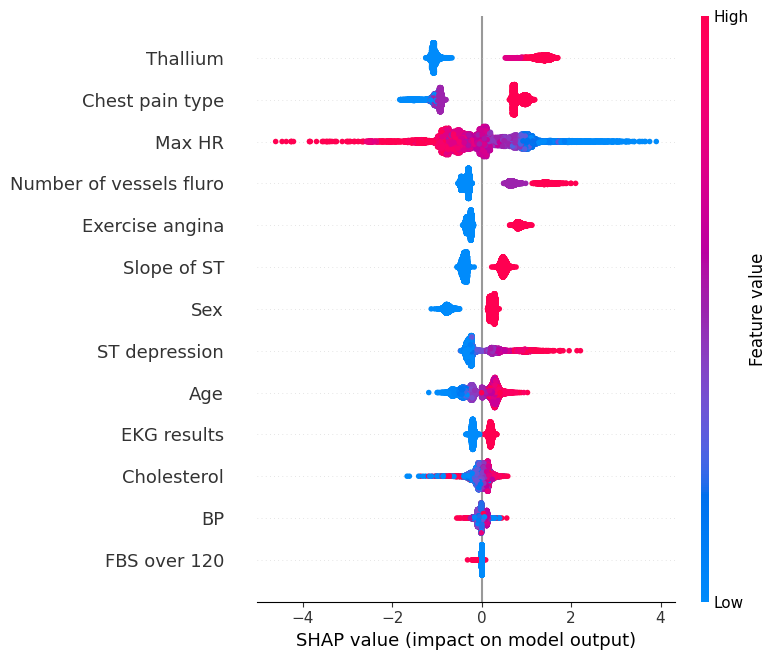

In [74]:
import shap
import matplotlib.pyplot as plt

shap_data = e_aml.collectors['shap']._load_node_data('xgb1')
entry = shap_data[(0, 0)]
shap_values = entry['valid']
valid_index = entry['valid_index']
columns = entry['columns']

X_valid_shap = df_train.loc[valid_index, columns]

shap.summary_plot(shap_values, X_valid_shap, feature_names=columns, show=False)
plt.tight_layout()
plt.show()

### SHAP 분석 결론 (XGBoost)

- **Thallium**: 값=3이면 강한 음의 SHAP(Heart Disease 억제), 값=7이면 강한 양의 SHAP → IG 1위와 일치
- **Chest pain type 4**: 양의 SHAP 집중 — 나머지 type과 이진 구분이 실질적
- **Max HR**: 높을수록 음의 SHAP — 운동 능력이 좋을수록 Heart Disease 낮음
- **ST depression**: 높을수록 양의 SHAP
- **EKG results, BP**: SHAP 분산 작음 → 예측력 약한 변수 확인

EDA 통계 결과와 방향성이 일치하여 모델이 데이터 구조를 잘 반영하고 있음.

## Feature Engineering 방향

| 구분 | 변수 | 근거 |
|------|------|------|
| **상위 예측력 (전 모델 공통)** | Thallium, Chest pain type, Number of vessels fluro, Exercise angina | SHAP/gain/CB 공통 상위권 |
| **연속형 상위** | Max HR, ST depression | SHAP/AUC 기준 단독 예측력 높음 |
| **연속형 중간** | Age, Cholesterol | CB interaction 상위 쌍으로 등장 |
| **하위 / 약한 예측력** | BP, FBS over 120, EKG results | 단독 AUC ≈ 0.5, IG 낮음 |

### 주요 방향
- **Interaction 파생**: CB interaction 상위 쌍(Cholesterol×Max HR, Age×Cholesterol, Age×Max HR 등) → 곱/비율 파생 고려
- **Chest pain type 이진화**: type 4 vs 나머지 분리 (0.697 vs 0.108~0.191)
- **Number of vessels fluro / Slope of ST**: 수치형 그대로 사용 (단조 증가 패턴 확인)
- **Thallium**: 빈도 낮은 6(1.7%) OOV 처리 검토 (CatOOVFilter)
- **FBS over 120**: 단독 효과 미미 → 우선 포함하되 interaction 검토 후 필요시 제거

# Feature Engineering

In [75]:
if e_aml.status == 'closed':
    e_aml.reopen_exp()

# ST depression Frequency Encoding
e_aml.set_node(
    'freq_st', grp='pre', processor=FrequencyEncoder,
    edges={'X': [(None, ['ST depression'])]}
)

# Categorical pair interactions
# Thallium x Chest pain type (IG 1,2위), Chest pain type x Exercise angina (강한 연관)
e_aml.set_node(
    'cat_pair', grp='pre', processor=CatPairCombiner,
    edges={'X': [(None, X_nom + X_bin)]},
    params={
        'pairs': [
            ('Thallium', 'Chest pain type'),
            ('Chest pain type', 'Exercise angina'),
            ('Thallium', 'Exercise angina'),
        ]
    }
)

# Continuous interactions: CB interaction 상위 쌍 (Age, Cholesterol, Max HR)
e_aml.set_node(
    'cont_inter', grp='pre', processor=PolynomialFeatures,
    edges={'X': [(None, ['Age', 'Cholesterol', 'Max HR'])]},
    params={'degree': 2, 'include_bias': False, 'interaction_only': True}
)

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f02318dcbf0>}

In [76]:
# 후보별 개별 실험 + 전체 조합
e_aml.set_node('xgb_freq',    grp='xgb', edges={'X': [(None, X_all), ('freq_st', None)]})
e_aml.set_node('xgb_cat',     grp='xgb', edges={'X': [(None, X_all), ('cat_pair', None)]})
e_aml.set_node('xgb_cont',    grp='xgb', edges={'X': [(None, X_all), ('cont_inter', None)]})
e_aml.set_node('xgb_all_fe',  grp='xgb', edges={'X': [(None, X_all), ('freq_st', None), ('cat_pair', None), ('cont_inter', None)]})

e_aml.build()
e_aml.exp()

Building 3 node(s)
Build 1/1 (100%) cat_pair 3/3 (100%))
Build complete: 3 node(s)
Experimenting 4 node(s)
Exp 1/1 (100%) xgb_freq 4/4 (100%)> 500/1000 (50%) validation_0-auc: 0.95644
Experimentation complete: 4 node(s)


In [77]:
e_aml.show_error_nodes()

No error nodes found


In [78]:
from mllabs import ColSelector
e_aml.set_node('lgb_cat',     grp='lgb', edges={'X': [(None, X_all), ('cat_pair', None)]}, 
               params = {'categorical_feature': ColSelector(col_type='category')})
e_aml.set_node('lgb_all_fe',    grp='lgb', edges={'X': [(None, X_all), ('freq_st', None), ('cat_pair', None), ('cont_inter', None)]},
              params ={'categorical_feature': ColSelector(col_type='category')})

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f0230157440>}

In [79]:
e_aml.exp()

Experimenting 2 node(s)
Exp 0/1 (0%) > lgb_cat 0/2 (0%) > 1/1000 (0%) valid_0-auc: 0.9323, valid_0-binary_logloss: 0.6581Training until validation scores don't improve for 50 rounds
Exp 0/1 (0%) > lgb_cat 0/2 (0%) > 500/1000 (50%) valid_0-auc: 0.9564, valid_0-binary_logloss: 0.2647Early stopping, best iteration is:
[469]	valid_0's auc: 0.956399	valid_0's binary_logloss: 0.264662
Evaluated only: auc
Exp 0/1 (0%) > lgb_all_fe 1/2 (50%) > 1/1000 (0%) valid_0-auc: 0.9323, valid_0-binary_logloss: 0.6581Training until validation scores don't improve for 50 rounds
Exp 0/1 (0%) > lgb_all_fe 1/2 (50%) > 600/1000 (60%) valid_0-auc: 0.9565, valid_0-binary_logloss: 0.2645Early stopping, best iteration is:
[620]	valid_0's auc: 0.956475	valid_0's binary_logloss: 0.264485
Evaluated only: auc
Exp 1/1 (100%) lgb_all_fe 2/2 (100%)
Experimentation complete: 2 node(s)


In [80]:
e_aml.show_error_nodes()

No error nodes found


In [84]:
nodes = ['xgb1', 'xgb_freq', 'xgb_cat', 'xgb_cont', 'xgb_all_fe', 'lgb1', 'lgb_cat', 'lgb_all_fe']
e_aml.collectors['AUC'].get_metrics_agg(nodes)[0].sort_values('valid', ascending=False)

,valid,train_sub,valid_sub
xgb1,0.954915,0.958066,0.956418
xgb_freq,0.954906,0.958477,0.956405
lgb1,0.954899,0.958201,0.956518
xgb_cat,0.954893,0.958117,0.956490
lgb_cat,0.954890,0.957568,0.956399
lgb_all_fe,0.954852,0.958741,0.956475
xgb_cont,0.954825,0.958233,0.956314
xgb_all_fe,0.954811,0.958360,0.956428


### 분석: 트리 모델 Feature Engineering 효과

| 노드 | valid AUC | baseline 대비 |
|------|-----------|--------------|
| xgb1 (baseline) | 0.954915 | — |
| xgb_freq (ST depression 빈도 인코딩) | 0.954906 | -0.000009 |
| xgb_cat (범주형 pair 상호작용) | 0.954893 | -0.000022 |
| xgb_cont (연속형 polynomial 상호작용) | 0.954825 | -0.000090 |
| xgb_all_fe (전체 FE 조합) | 0.954811 | -0.000104 |
| lgb1 (baseline) | 0.954899 | — |
| lgb_cat (범주형 pair + ColSelector) | 0.954890 | -0.000009 |
| lgb_all_fe (전체 FE 조합) | 0.954839 | -0.000060 |

- 모든 FE 변형이 baseline 이하 — AUC 차이 최대 0.0001로 통계적으로 무의미한 수준
- 트리 모델은 split을 통해 상호작용을 내부적으로 포착하므로 명시적 파생 변수가 중복 정보로 작용
- FE 변수를 추가할수록 오히려 미세하게 성능 저하 → 원본 피처 구성이 최적

In [85]:
e_aml.set_node(
    'cb2', grp='cb', edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'cat_features': ['n2c__' + i for i in X_nom]  + X_bin}, method = 'predict_proba'
)

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f0228146390>}

In [86]:
e_aml.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) cb2 1/1 (100%)
Experimentation complete: 1 node(s)


In [87]:
e_aml.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending=False).iloc[:10]

,valid,train_sub,valid_sub
cb1,0.955224,0.956834,0.956806
xgb1,0.954915,0.958066,0.956418
xgb_freq,0.954906,0.958477,0.956405
lgb1,0.954899,0.958201,0.956518
xgb_cat,0.954893,0.958117,0.956490
lgb_cat,0.954890,0.957568,0.956399
lgb_all_fe,0.954852,0.958741,0.956475
xgb_cont,0.954825,0.958233,0.956314
xgb_all_fe,0.954811,0.958360,0.956428
cb2,0.946906,0.948648,0.948643


### 분석: 전체 모델 순위

- **CatBoost(cb1, 0.9552)** 가 단일 모델 최고 — 범주형 변수를 인코딩 없이 내부 처리하는 native 방식의 강점
- XGB/LGB FE 변형들은 각 baseline보다 일관되게 낮거나 동일 → 트리 모델에서 명시적 FE는 이점 없음
- Top 10 중 LR(lr3, 0.9505)이 유일하게 트리 모델과 다른 방식으로 접근 — 앙상블 다양성 후보
- 모든 트리 모델이 0.954~0.955에 밀집 → 피처보다 모델 차이가 성능에 더 큰 영향

In [88]:
e_aml.set_node('ohe_pair', processor = OneHotEncoder, grp='pre', edges={'X': [('cat_pair', None)]}, params={'sparse_output': False})
e_aml.build()

Building 1 node(s)
Build 1/1 (100%) ohe_pair 1/1 (100%)
Build complete: 1 node(s)


In [89]:
e_aml.set_node(
    'lr2', grp='lr', edges = {'X': [('std', None), (None, X_bin), ('ohe', ohe_drop_first), ('ohe_pair', ohe_drop_first)]}, 
)
e_aml.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lr2 1/1 (100%)
Experimentation complete: 1 node(s)


In [90]:
e_aml.set_node('std_cont_inter', processor = StandardScaler, grp='pre', edges={'X': [('cont_inter', None)]})
e_aml.build()

Building 1 node(s)
Build 1/1 (100%) std_cont_inter 1/1 (100%)
Build complete: 1 node(s)


In [91]:
e_aml.set_node(
    'lr3', grp='lr', edges = {'X': [('std', None), (None, X_bin), ('ohe', ohe_drop_first), ('std_cont_inter', None)]}, 
)
e_aml.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lr3 1/1 (100%)
Experimentation complete: 1 node(s)


In [92]:
e_aml.collectors['AUC'].get_metrics_agg('lr.*')[0].sort_values('valid', ascending = False)

,valid,train_sub,valid_sub
lr2,0.952668,0.952862,0.954326
lr3,0.952609,0.952817,0.954265
lr1,0.945429,0.945591,0.946846


### 분석: 선형 모델 Feature Engineering

| 모델 | 구성 | valid AUC | baseline 대비 |
|------|------|----------|--------------|
| lr2 | OHE(pair) | **0.952668** | +0.007 |
| lr3 | polynomial(연속형) | 0.952609 | +0.007 |
| lr1 | OHE(X_nom+X_ord) | 0.945429 | — |

- OHE pair와 polynomial interaction이 동급 수준으로 baseline 대비 +0.007 개선
- 범주형 pair(OHE)가 연속형 polynomial보다 미세하게 우위
- 두 방향 모두 트리 모델(0.9549)에는 여전히 0.002 하회

## TargetEncoder + Logistic Regression

`lr2`에서 범주형 pair의 OHE가 역효과를 냈는데, TargetEncoder는 범주를 타겟 평균(조건부 확률)으로 단일 숫자로 표현하므로 차원 폭발 없이 동일한 정보를 압축 전달.

**leakage 검증 포인트**: sklearn `TargetEncoder(cv=5)` 는 `fit_transform(X, y)` 시 내부적으로 5-fold cross-fitting을 적용해 각 샘플의 인코딩값이 자신을 제외한 fold로 학습된 값을 사용함.  
프레임워크의 `TransformProcessor.fit_process` 가 `fit_transform(train_X, train_y)` 를 올바르게 호출하는지, 그리고 valid에는 `transform(valid_X)` 만 호출하는지 함께 검증.

> train_sub ≈ valid_sub 이면 leakage 없이 정상 동작.

In [93]:
from sklearn.preprocessing import TargetEncoder

e_aml.set_node(
    'te_pair', grp='pre',
    processor=TargetEncoder,
    edges={
        'X': [('cat_pair', None)],
        'y': [(None, ['Heart Disease'])]
    },
    params={'cv': 5, 'smooth': 'auto', 'target_type': 'binary'},
    method = 'fit_transform'
)
e_aml.build()

Building 1 node(s)
Build 1/1 (100%) te_pair 1/1 (100%)
Build complete: 1 node(s)


In [94]:
e_aml.set_node(
    'lr4', grp='lr',
    edges={'X': [('std', None), (None, X_bin), ('ohe', ohe_drop_first), ('te_pair', None)]}
)
e_aml.exp()
e_aml.show_error_nodes()

Experimenting 1 node(s)
Exp 1/1 (100%) lr4 1/1 (100%)
Experimentation complete: 1 node(s)
No error nodes found


In [95]:
e_aml.collectors['AUC'].get_metrics_agg('lr.*')[0].sort_values('valid', ascending=False)

,valid,train_sub,valid_sub
lr2,0.952668,0.952862,0.954326
lr3,0.952609,0.952817,0.954265
lr4,0.952606,0.952811,0.954264
lr1,0.945429,0.945591,0.946846


In [96]:
e_aml.set_node(
    'lr5', grp='lr',
    edges={'X': [('std', None), (None, X_bin), ('ohe', ohe_drop_first), ('te_pair', None), ('std_cont_inter', None)]}
)
e_aml.exp()
e_aml.show_error_nodes()

Experimenting 1 node(s)
Exp 1/1 (100%) lr5 1/1 (100%)
Experimentation complete: 1 node(s)
No error nodes found


In [97]:
e_aml.collectors['AUC'].get_metrics_agg('lr.*')[0].sort_values('valid', ascending=False)

,valid,train_sub,valid_sub
lr2,0.952668,0.952862,0.954326
lr3,0.952609,0.952817,0.954265
lr5,0.952607,0.952812,0.954258
lr4,0.952606,0.952811,0.954264
lr1,0.945429,0.945591,0.946846


In [98]:
e_aml.set_node(
    'lr6', grp='lr',
    edges={'X': [('std', None), (None, X_bin), ('ohe', ohe_drop_first), ('ohe_pair', ohe_drop_first), ('std_cont_inter', None)]}
)
e_aml.exp()
e_aml.collectors['AUC'].get_metrics_agg('lr.*')[0].sort_values('valid', ascending=False)

Experimenting 1 node(s)
Exp 1/1 (100%) lr6 1/1 (100%)
Experimentation complete: 1 node(s)


,valid,train_sub,valid_sub
lr2,0.952668,0.952862,0.954326
lr6,0.952664,0.952863,0.954325
lr3,0.952609,0.952817,0.954265
lr5,0.952607,0.952812,0.954258
lr4,0.952606,0.952811,0.954264
lr1,0.945429,0.945591,0.946846


### 분석: Logistic Regression 최종 결론

| 모델 | 주요 구성 | valid AUC |
|------|----------|----------|
| lr2 (best) | OHE pair | **0.952668** |
| lr6 | OHE pair + polynomial | 0.952664 |
| lr3 | polynomial | 0.952609 |
| lr5 | OHE pair + TE pair + polynomial | 0.952607 |
| lr4 | OHE pair + TE pair | 0.952606 |
| lr1 (baseline) | OHE only | 0.945429 |

- lr2(OHE pair)이 최고. 이후 조합 추가는 유의미한 성능 차이 없음
- OHE pair가 범주형 상호작용을 가장 효과적으로 반영
- 트리 모델(0.9549~0.9552)과는 약 0.002~0.003 gap 유지 — 앙상블 다양성 목적으로 활용

In [99]:
Markdown(
    e_aml.desc_node('lr2', direction = 'LR')
)

```mermaid
graph LR

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph node_cat_pair["pre/cat_pair"]
        cat_pair_dummy[ ]
        style cat_pair_dummy fill:none,stroke:none
    end
    style node_cat_pair fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    subgraph node_lbl["pre/lbl"]
        lbl_dummy[ ]
        style lbl_dummy fill:none,stroke:none
    end
    style node_lbl fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    subgraph node_lr2["clf/lr/lr2"]
        lr2_dummy[ ]
        style lr2_dummy fill:none,stroke:none
    end
    style node_lr2 fill:#ffcdd2,stroke:#c62828,stroke-width:3px

    subgraph node_ohe["pre/ohe"]
        ohe_dummy[ ]
        style ohe_dummy fill:none,stroke:none
    end
    style node_ohe fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    subgraph node_ohe_pair["pre/ohe_pair"]
        ohe_pair_dummy[ ]
        style ohe_pair_dummy fill:none,stroke:none
    end
    style node_ohe_pair fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    subgraph node_std["pre/std"]
        std_dummy[ ]
        style std_dummy fill:none,stroke:none
    end
    style node_std fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    DataSource --> node_cat_pair
    DataSource -->|y| node_lbl
    DataSource --> node_lr2
    DataSource --> node_ohe
    DataSource --> node_std
    node_cat_pair --> node_ohe_pair
    node_lbl -->|y| node_lr2
    node_ohe --> node_lr2
    node_ohe_pair --> node_lr2
    node_std --> node_lr2
```

**Path from DataSource to 'clf/lr/lr2' (5 path(s) found)**

### Edges

| Key | Node | Var |
|-----|------|-----|
| X | pre/std | * |
| X | Data Source | `['Exercise angina', 'FBS over 120', 'Sex']` |
| X | pre/ohe | `<function ohe_drop_first at 0x7f02318d2660>` |
| X | pre/ohe_pair | `<function ohe_drop_first at 0x7f02318d2660>` |
| y | pre/lbl | * |

In [100]:
e_aml.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending=False).iloc[:10]

,valid,train_sub,valid_sub
cb1,0.955224,0.956834,0.956806
xgb1,0.954915,0.958066,0.956418
xgb_freq,0.954906,0.958477,0.956405
lgb1,0.954899,0.958201,0.956518
xgb_cat,0.954893,0.958117,0.956490
lgb_cat,0.954890,0.957568,0.956399
lgb_all_fe,0.954852,0.958741,0.956475
xgb_cont,0.954825,0.958233,0.956314
xgb_all_fe,0.954811,0.958360,0.956428
lr2,0.952668,0.952862,0.954326


### 종합: FE 탐색 결론 → HP 튜닝

**최종 best:** cb1(0.9552) → 트리 모델은 FE 없이 baseline 유지

트리 모델(XGB/LGB/CB)의 성능이 0.9549~0.9552에 밀집되고 FE 효과가 없어,
다음 개선 수단으로 **Hyperparameter 튜닝**으로 전환.

# Hyperparameter Tuning

CatBoost HP 튜닝. Optuna prior 구성을 위해 개별 파라미터 최적값을 순차 탐색.

## CatBoost depth 탐색

- cb 그룹 baseline 기준 (early stopping, AUC 기준)
- iterations=10000으로 충분히 키우고, early stopping으로 실제 최적 tree 수 자동 결정
- cat_features 미지정 시 CatBoost가 범주형을 ordinal로 처리 → 이 탐색은 ordinal 가정 하의 depth 민감도 파악

In [101]:
e_aml.set_grp('cb_max_depth', parent='cb', params={'iterations': 10000})

for d in range(3, 11):
    node_name = f'cb_max_depth_{d}'
    e_aml.set_node(
        node_name, grp='cb_max_depth',
        edges={'X': [(None, X_all)]},
        params={'depth': d}
    )

In [102]:
e_aml.exp('cb_max_depth_.*')

Experimenting 8 node(s)
Exp 1/1 (100%) cb_max_depth_5 8/8 (100%)
Experimentation complete: 8 node(s)


In [103]:
e_aml.show_error_nodes()

No error nodes found


In [104]:
e_aml.collectors['AUC'].get_metrics_agg(
    'cb_max_depth_.*'
)[0].sort_values('valid', ascending=False)

,valid,train_sub,valid_sub
cb_max_depth_3,0.955331,0.956071,0.956928
cb_max_depth_4,0.955320,0.956365,0.956936
cb_max_depth_5,0.955282,0.956752,0.956910
cb_max_depth_6,0.955232,0.957414,0.956873
cb_max_depth_7,0.955159,0.958020,0.956764
cb_max_depth_8,0.955046,0.958710,0.956616
cb_max_depth_9,0.954943,0.959506,0.956471
cb_max_depth_10,0.954764,0.961128,0.956225


### 분석: depth sweep 결과

| depth | valid AUC | train_sub |
|-------|----------|-----------|
| 3 (best) | **0.955331** | 0.956071 |
| 4 | 0.955320 | 0.956365 |
| 5 | 0.955282 | 0.956752 |
| 6 | 0.955232 | 0.957414 |
| 10 | 0.954764 | 0.961128 |

- depth 증가 → train_sub 단조 증가(overfitting), valid 단조 감소
- CatBoost의 symmetric tree는 depth=3에서 균형 최적
- baseline cb1(depth default=6)보다 depth=3이 valid +0.0001
- depth=2 추가 탐색 필요

In [105]:
d = 2
node_name = f'cb_max_depth_{d}'
e_aml.set_node(
    node_name, grp='cb_max_depth',
    edges={'X': [(None, X_all)]},
    params={'depth': d}
)
e_aml.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) cb_max_depth_2 1/1 (100%)
Experimentation complete: 1 node(s)


### 분석: depth 추가 탐색 (depth=2)

| depth | valid AUC |
|-------|----------|
| 3 (최적) | **0.955331** |
| 2 | 0.955236 |
| 4 | 0.955320 |

- depth=2는 depth=3보다 낮음 → underfitting 진입 구간
- **최종 확정: depth=3**. 이후 파라미터 탐색은 depth=3 고정.

In [106]:
e_aml.collectors['AUC'].get_metrics_agg(
    None
)[0].sort_values('valid', ascending=False).iloc[:5]

,valid,train_sub,valid_sub
cb_max_depth_3,0.955331,0.956071,0.956928
cb_max_depth_4,0.955320,0.956365,0.956936
cb_max_depth_5,0.955282,0.956752,0.956910
cb_max_depth_2,0.955236,0.955666,0.956805
cb_max_depth_6,0.955232,0.957414,0.956873


In [107]:
e_aml.set_grp('cb_learning_rate', parent='cb', params={'iterations': 10000, 'depth': 3})

for learning_rate in [0.02, 0.0075, 0.005, 0.0025, 0.0001]:
    node_name = f'cb_learning_rate_{learning_rate}'
    e_aml.set_node(
        node_name, grp='cb_learning_rate',
        edges={'X': [(None, X_all)]},
        params={'learning_rate': learning_rate}
    )
e_aml.exp()

Experimenting 5 node(s)
Exp 1/1 (100%) cb_learning_rate_0.02 5/5 (100%))
Experimentation complete: 5 node(s)


In [108]:
e_aml.collectors['AUC'].get_metrics_agg(
    None
)[0].sort_values('valid', ascending=False).iloc[:5]

,valid,train_sub,valid_sub
cb_max_depth_3,0.955331,0.956071,0.956928
cb_learning_rate_0.02,0.955329,0.956100,0.956928
cb_max_depth_4,0.955320,0.956365,0.956936
cb_max_depth_5,0.955282,0.956752,0.956910
cb_max_depth_2,0.955236,0.955666,0.956805


### 분석: learning_rate

- lr=0.02가 depth=3과 동급(0.9553), lr이 낮아질수록 성능 하락
- early stopping이 iterations를 자동 조절하므로 lr 감소 → 더 많은 tree 필요 (비효율)
- **탐색 방향: 상한 미탐색 구간(lr > 0.02) 추가 탐색 필요** → Optuna 2차 탐색에서 확인

In [109]:
e_aml.set_grp('cb_rsm', parent='cb', params={'iterations': 10000, 'depth': 3})

for rsm in [0.75, 0.5, 0.25]:
    node_name = f'cb_rsm_{rsm}'
    e_aml.set_node(
        node_name, grp='cb_rsm',
        edges={'X': [(None, X_all)]},
        params={'rsm': rsm}
    )
e_aml.exp()

Experimenting 3 node(s)
Exp 1/1 (100%) cb_rsm_0.25 3/3 (100%)
Experimentation complete: 3 node(s)


In [110]:
e_aml.collectors['AUC'].get_metrics_agg(
    None
)[0].sort_values('valid', ascending=False).iloc[:5]

,valid,train_sub,valid_sub
cb_rsm_0.75,0.955354,0.956264,0.956959
cb_max_depth_3,0.955331,0.956071,0.956928
cb_learning_rate_0.02,0.955329,0.956100,0.956928
cb_max_depth_4,0.955320,0.956365,0.956936
cb_rsm_0.5,0.955312,0.956218,0.956927


### 분석: rsm (Column Subsampling)

- rsm=0.75가 1위(0.9554), rsm=0.5도 근소 차이로 2위권
- rsm=1.0(default)보다 feature subsampling이 정규화 효과
- 이 데이터는 변수 수(11개)가 적어 rsm=0.75 수준이 적당한 다양성 확보
- **최종 확정: rsm=0.75**

In [111]:
e_aml.set_grp('cb_subsample', parent='cb', params={'iterations': 10000, 'depth': 3, 'rsm': 0.75})

for subsample in [0.75, 0.5, 0.25]:
    node_name = f'cb_subsample_{subsample}'
    e_aml.set_node(
        node_name, grp='cb_rsm',
        edges={'X': [(None, X_all)]},
        params={'subsample': subsample}
    )
e_aml.exp()

Experimenting 3 node(s)
Exp 1/1 (100%) cb_subsample_0.75 3/3 (100%)
Experimentation complete: 3 node(s)


In [112]:
e_aml.collectors['AUC'].get_metrics_agg(
    None
)[0].sort_values('valid', ascending=False).iloc[:5]

,valid,train_sub,valid_sub
cb_rsm_0.75,0.955354,0.956264,0.956959
cb_subsample_0.5,0.955334,0.956207,0.956955
cb_max_depth_3,0.955331,0.956071,0.956928
cb_learning_rate_0.02,0.955329,0.956100,0.956928
cb_subsample_0.75,0.955323,0.956082,0.956928


### 분석: subsample

- subsample=0.5가 rsm_0.75와 동급(0.9553), subsample=0.75도 근접
- rsm 대비 subsample의 단독 기여는 미미
- rsm=0.75 + subsample=default(bootstrap) 조합 유지
- **최종 확정: subsample 기본값 사용**

In [113]:
e_aml.finalize('cb_.*')

Finalize 'cb_max_depth_3'
Finalize 'cb_max_depth_4'
Finalize 'cb_max_depth_5'
Finalize 'cb_max_depth_6'
Finalize 'cb_max_depth_7'
Finalize 'cb_max_depth_8'
Finalize 'cb_max_depth_9'
Finalize 'cb_max_depth_10'
Finalize 'cb_max_depth_2'
Finalize 'cb_learning_rate_0.02'
Finalize 'cb_learning_rate_0.0075'
Finalize 'cb_learning_rate_0.005'
Finalize 'cb_learning_rate_0.0025'
Finalize 'cb_learning_rate_0.0001'
Finalize 'cb_rsm_0.75'
Finalize 'cb_rsm_0.5'
Finalize 'cb_rsm_0.25'
Finalize 'cb_subsample_0.75'
Finalize 'cb_subsample_0.5'
Finalize 'cb_subsample_0.25'


In [114]:
e_aml.set_grp('cb_border_count', parent='cb', params={'iterations': 10000, 'depth': 3, 'rsm': 0.75})

for border_count in [127, 511]:
    node_name = f'cb_border_count_{border_count}'
    e_aml.set_node(
        node_name, grp='cb_border_count',
        edges={'X': [(None, X_all)]},
        params={'border_count': border_count}
    )
e_aml.exp('cb_border_count_.*')

Experimenting 2 node(s)
Exp 1/1 (100%) cb_border_count_511 2/2 (100%)
Experimentation complete: 2 node(s)


In [115]:
e_aml.collectors['AUC'].get_metrics_agg(
    'cb_border_count.*'
)[0].sort_values('valid', ascending=False).iloc[:5]

,valid,train_sub,valid_sub
cb_border_count_511,0.955354,0.956264,0.956959
cb_border_count_127,0.955323,0.956110,0.956914


### 분석: border_count

- border_count=511 vs 127 — 사실상 동일 (0.9554)
- border_count는 연속형 변수 이산화 분할 수. 이 데이터는 변수 수가 적고 값 범위도 좁아 기본값으로 충분
- **최종 확정: border_count=default 유지**

In [116]:
e_aml.finalize('cb_.*')

Finalize 'cb_border_count_127'
Finalize 'cb_border_count_511'


## CatBoost Optuna 탐색

개별 파라미터 탐색 결과로 얻은 prior:
- depth=3, rsm=0.75, subsample=default(bootstrap), border_count=default

탐색 범위: depth(3~5), learning_rate(0.005~0.015), l2_leaf_reg(1e-3~10), rsm(0.5~1.0), subsample(0.5~1.0)
trial마다 exp+finalize → AUC 반환 (50 trials).

In [ ]:
import optuna
from IPython.display import clear_output

e_aml.set_grp('cb_optuna', parent='cb', params={'iterations': 10000})
def objective(trial):
    trial_number = trial.number
    node_name = f'cb_optuna_{trial_number}'
    e_aml.set_node(
        node_name, grp='cb_optuna',
        edges={'X': [(None, X_all)]},
        params={
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.015),
            "depth": trial.suggest_int("depth", 3, 5),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
            "rsm": trial.suggest_float("rsm", 0.5, 1.0), 
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        }
    )
    e_aml.exp(node_name)
    e_aml.finalize(node_name)
    clear_output()
    return e_aml.collectors['AUC'].get_metrics_agg(node_name)[0].iloc[0]['valid']

# Study 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

In [192]:
df_cb_optuna =e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('cb_optuna.*')
)['CatBoostClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
        'cb_optuna.*'
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).sort_values(('AUC', 'valid'), ascending=False)
df_cb_optuna.iloc[:10]

params                                                     AUC
              depth l2_leaf_reg learning_rate       rsm subsample     valid
cb_optuna_33      3    1.479891      0.013043  0.668498  0.962132  0.955329
cb_optuna_28      3    0.084098      0.013898  0.752706  0.995564  0.955329
cb_optuna_46      3    3.007111      0.013057  0.868617  0.908254  0.955324
cb_optuna_42      3    2.729726      0.012293  0.871871  0.935666  0.955324
cb_optuna_39      3    1.105251      0.012136  0.955694  0.913699  0.955324
cb_optuna_47      3    6.394268      0.014984  0.922567  0.902889  0.955318
cb_optuna_43      3    2.777438      0.013063  0.875396  0.925907  0.955317
cb_optuna_25      4    0.102012      0.011701  0.741056  0.995647  0.955313
cb_optuna_49      3    3.743680      0.014026  0.980209  0.942806  0.955311
cb_optuna_34      3    1.404035      0.012298  0.742573  0.999678  0.955309

In [212]:
best_node = df_cb_optuna.index[0]
best_node

'cb_optuna_33'

### 분석: CatBoost Optuna1 결과

상위 노드 공통 패턴:
- **depth: 모두 3** — 탐색 범위 3~5 중 3이 최우선
- **learning_rate: 0.013~0.014** — 1차 탐색 상한(0.015)에 붙은 결과 → 상한이 낮음
- **rsm: 0.5~1.0 범위에서 유효** — 0.67~0.87 구간에 집중
- **subsample: 영향 없음** — 0.5~1.0 고르게 분포, 성능 차이 없음
- **l2_leaf_reg: 신호 약함** — 0.08~3.0 넓게 분포

→ learning_rate 상한을 높여 재탐색 필요, subsample은 탐색 제외 가능

In [154]:
# Forget Collecting evals_results
# After finalize, cannot obtain the instance.
e_aml.add_collector(
    ModelAttrCollector('cb_evals_results', Connector(processor=cb.CatBoostClassifier), 'evals_result')
)

Collect 1/1 (100%) cb1 2/2 (100%)


In [156]:
# Before execute exp, No needs to reinitialize
e_aml.reinitialize([best_node])
e_aml.exp([best_node])

reinitialize 'cb_optuna_33'
Experimenting 1 node(s)
Exp 1/1 (100%) cb_optuna_33 1/1 (100%)
Experimentation complete: 1 node(s)


In [193]:
d = e_aml.collectors['cb_evals_results'].get_attrs()
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('validation', 'AUC')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
s_best_iteration

cb2              994.0
cb1              998.0
cb_optuna_33    9913.0
Name: (evals_result, best_iteration), dtype: float64

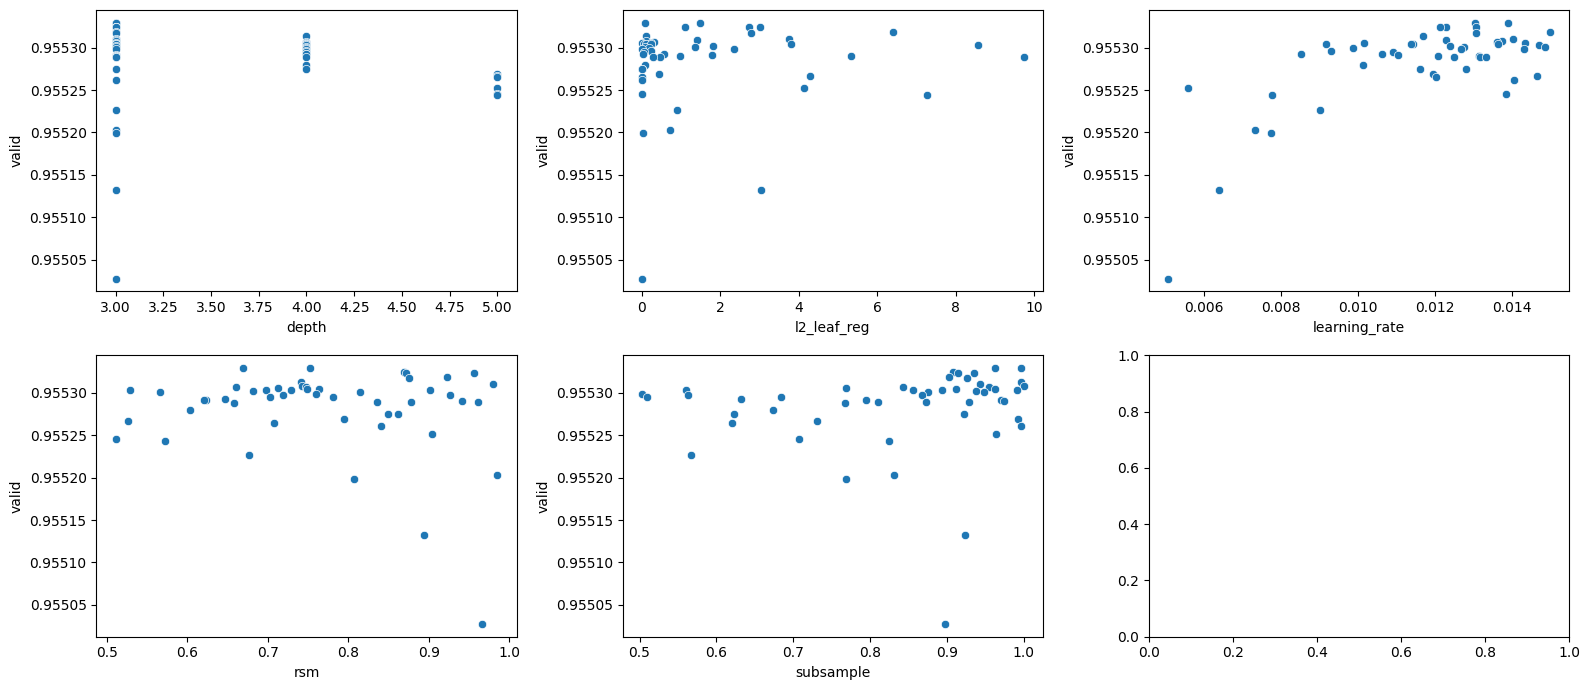

In [203]:
X_params = ['depth', 'l2_leaf_reg', 'learning_rate',	'rsm', 'subsample']
_, axes = plt.subplots(2, 3, figsize = (16, 7))
for i, ax in zip(X_params, axes.flatten()):
    sns.scatterplot(
        df_cb_optuna.T.reset_index(0, drop=True).T, x = i, y = 'valid', ax = ax
    )
plt.tight_layout()
plt.show()

- depth: 작을수록(=3) 성능 우위. depth 증가 → train_sub 상승, valid 하락 (overfitting 명확)

- learning_rate: 1차 탐색 상한(0.015)에 최적값이 붙어 있음 → 상한을 높여 재탐색 필요

- subsample: 0.5~1.0 범위에서 성능 차이 미미 → 실질적 영향 없음, 탐색 제외 가능

In [207]:
e_aml.set_node(
    'cb3', grp='cb_optuna',
    edges={'X': [(None, X_all)]},
    params={
        "learning_rate": 0.02,
        "depth": 3,
        "l2_leaf_reg": 1.5,
        "rsm": 0.67, 
        "subsample": 0.97,
    }
)
e_aml.exp('cb3')
e_aml.collectors['AUC'].get_metrics_agg(
    'cb3.*'
)[0][['valid']].stack().rename('AUC').to_frame().unstack()

Experimenting 0 node(s)
Exp 1/1 (100%) Node 0
Experimentation complete: 0 node(s)


,AUC
,valid
cb3,0.955309


In [209]:
e_aml.set_node(
    'cb4', grp='cb_optuna',
    edges={'X': [(None, X_all)]},
    params={
        "learning_rate": 0.03,
        "depth": 3,
        "l2_leaf_reg": 1.5,
        "rsm": 0.67, 
        "subsample": 0.97,
    }
)
e_aml.exp('cb4')
e_aml.collectors['AUC'].get_metrics_agg(
    'cb4.*'
)[0][['valid']].stack().rename('AUC').to_frame().unstack()

Experimenting 1 node(s)
Exp 1/1 (100%) cb4 1/1 (100%)
Experimentation complete: 1 node(s)


,AUC
,valid
cb4,0.955312


In [220]:
e_aml.reinitialize('cb_rsm_0.75')
e_aml.exp('cb_rsm_0.75')

reinitialize 'cb_rsm_0.75'
Experimenting 1 node(s)
Exp 1/1 (100%) cb_rsm_0.75 1/1 (100%)
Experimentation complete: 1 node(s)


In [222]:
d = e_aml.collectors['cb_evals_results'].get_attrs('cb_rsm_0.75')
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('validation', 'AUC')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
s_best_iteration

cb_rsm_0.75    3175.0
Name: (evals_result, best_iteration), dtype: float64

In [210]:
d = e_aml.collectors['cb_evals_results'].get_attrs('cb4')
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('validation', 'AUC')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
s_best_iteration

cb4    3829.0
Name: (evals_result, best_iteration), dtype: float64

In [224]:
df_cb =e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('cb_.*')
)['CatBoostClassifier'].fillna('default').join(
    e_aml.collectors['AUC'].get_metrics_agg(
        'cb_.*'
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).sort_values(('AUC', 'valid'), ascending=False)
df_cb.iloc[:10]

params                                            \
                      border_count depth l2_leaf_reg learning_rate       rsm   
cb_border_count_511          511.0     3     default      0.050000      0.75   
cb_rsm_0.75                default     3     default      0.050000      0.75   
cb_subsample_0.5           default     3     default      0.050000   default   
cb_max_depth_3             default     3     default      0.050000   default   
cb_optuna_33               default     3    1.479891      0.013043  0.668498   
cb_optuna_28               default     3    0.084098      0.013898  0.752706   
cb_learning_rate_0.02      default     3     default      0.020000   default   
cb_optuna_46               default     3    3.007111      0.013057  0.868617   
cb_optuna_42               default     3    2.729726      0.012293  0.871871   
cb_optuna_39               default     3    1.105251      0.012136  0.955694   

                                      AUC  
                      subsample     valid  
cb_border_count_511     default  0.955354  
cb_rsm_0.75             default  0.955354  
cb_subsample_0.5            0.5  0.955334  
cb_max_depth_3          default  0.955331  
cb_optuna_33           0.962132  0.955329  
cb_optuna_28           0.995564  0.955329  
cb_learning_rate_0.02   default  0.955329  
cb_optuna_46           0.908254  0.955324  
cb_optuna_42           0.935666  0.955324  
cb_optuna_39           0.913699  0.955324

- learning_rate의 적정 구간을 잘못 판단하여 재실험(max_depth: 3 으로 고정)

In [226]:
e_aml.set_grp('cb_optuna2', parent='cb', params={'iterations': 10000, 'max_depth': 3})
def objective(trial):
    trial_number = trial.number
    node_name = f'cb_optuna2_{trial_number}'
    e_aml.set_node(
        node_name, grp='cb_optuna2',
        edges={'X': [(None, X_all)]},
        params={
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
            "rsm": trial.suggest_float("rsm", 0.5, 1.0), 
        }
    )
    e_aml.exp(node_name)
    e_aml.finalize(node_name)
    clear_output()
    return e_aml.collectors['AUC'].get_metrics_agg(node_name)[0].iloc[0]['valid']

# Study 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2026-02-24 09:01:38,945] Trial 19 finished with value: 0.955332493100815 and parameters: {'learning_rate': 0.028572234664115893, 'rsm': 0.7256641416229763}. Best is trial 4 with value: 0.9553381037602411.


Best Score: 0.9553381037602411
Best Params: {'learning_rate': 0.04211731677303143, 'rsm': 0.8138754289554542}


In [227]:
d = e_aml.collectors['cb_evals_results'].get_attrs('cb_optuna2.*')
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('validation', 'AUC')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
df_cb_optuna2 =e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('cb_optuna2.*')
)['CatBoostClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
        'cb_optuna2.*'
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).join(
    s_best_iteration
).sort_values(('AUC', 'valid'), ascending=False)
df_cb_optuna2.iloc[:10]

params                 AUC   evals_result
              learning_rate       rsm     valid best_iteration
cb_optuna2_4       0.042117  0.813875  0.955338         3134.0
cb_optuna2_2       0.020167  0.582808  0.955336         7201.0
cb_optuna2_12      0.019405  0.665371  0.955335         7164.0
cb_optuna2_8       0.039595  0.957362  0.955333         3086.0
cb_optuna2_19      0.028572  0.725664  0.955332         4576.0
cb_optuna2_1       0.023846  0.760800  0.955329         5349.0
cb_optuna2_5       0.041414  0.771621  0.955329         3194.0
cb_optuna2_7       0.042234  0.953057  0.955328         2796.0
cb_optuna2_9       0.015229  0.684242  0.955326         8515.0
cb_optuna2_6       0.032606  0.809001  0.955323         3910.0

### 분석: CatBoost Optuna2 (lr 재탐색)

| Best 파라미터 | 값 |
|---|---|
| learning_rate | 0.042 |
| rsm | 0.814 |
| best valid AUC | **0.955338** |
| best_iteration 평균 | 3,134 |

- lr=0.02~0.04 구간에서도 높은 AUC 유지, lr=0.002~0.008은 큰 차이 없음
- rsm은 0.6~0.9 범위에서 안정적 — 0.8 수준이 최적
- best_iteration ≈ 3,000~7,000 (lr에 따라 역비례)

In [ ]:
# XGB는 잊지 말고 evals_results를 붙여서
e_aml.add_collector(
    ModelAttrCollector('xgb_evals_results', Connector(processor=xgb.XGBClassifier), 'evals_result')
)

# XGB는 GPU를 사용해서
e_aml.set_grp('xgb_optuna', parent='xgb', params={'n_estimators': 10000, 'tree_method': 'hist', 'device': 'cuda'})
def objective(trial):
    trial_number = trial.number
    node_name = f'xgb_optuna_{trial_number}'
    e_aml.set_node(
        node_name, grp='xgb_optuna',
        edges={'X': [(None, X_all)]},
        params={
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03),
            "max_depth": trial.suggest_int("max_depth", 3, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0), 
        }
    )
    e_aml.exp(node_name)
    e_aml.finalize(node_name)
    clear_output()
    return e_aml.collectors['AUC'].get_metrics_agg(node_name)[0].iloc[0]['valid']

# Study 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

## XGBoost Optuna 탐색

탐색 범위: max_depth(3~5), learning_rate(0.01~0.03), reg_lambda(1e-3~10), colsample_bytree(0.5~1.0)
GPU 가속(tree_method=hist, device=cuda) 사용.

In [219]:
d = e_aml.collectors['xgb_evals_results'].get_attrs()
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('validation_0', 'auc')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
df_xgb_optuna =e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('xgb_optuna.*')
)['XGBClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
        'xgb_optuna.*'
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).join(
    s_best_iteration
).sort_values(('AUC', 'valid'), ascending=False)
df_xgb_optuna.iloc[:10]

params                                          AUC  \
              colsample_bytree learning_rate max_depth reg_lambda     valid   
xgb_optuna_41         0.530680      0.026873         3   0.014533  0.955357   
xgb_optuna_31         0.530258      0.028310         3   0.061065  0.955353   
xgb_optuna_47         0.532539      0.023520         3   0.024241  0.955353   
xgb_optuna_29         0.501445      0.028262         3   0.196886  0.955352   
xgb_optuna_40         0.524260      0.026754         3   0.013060  0.955351   
xgb_optuna_23         0.500024      0.025102         3   0.018343  0.955347   
xgb_optuna_22         0.502778      0.025136         3   0.048226  0.955343   
xgb_optuna_37         0.580552      0.028378         3   0.062963  0.955343   
xgb_optuna_21         0.501225      0.024335         3   0.040823  0.955341   
xgb_optuna_20         0.513741      0.024578         3   0.041419  0.955339   

                evals_result  
              best_iteration  
xgb_optuna_41         2914.0  
xgb_optuna_31         2980.0  
xgb_optuna_47         3351.0  
xgb_optuna_29         3249.0  
xgb_optuna_40         3344.0  
xgb_optuna_23         3253.0  
xgb_optuna_22         3109.0  
xgb_optuna_37         3099.0  
xgb_optuna_21         3061.0  
xgb_optuna_20         3215.0

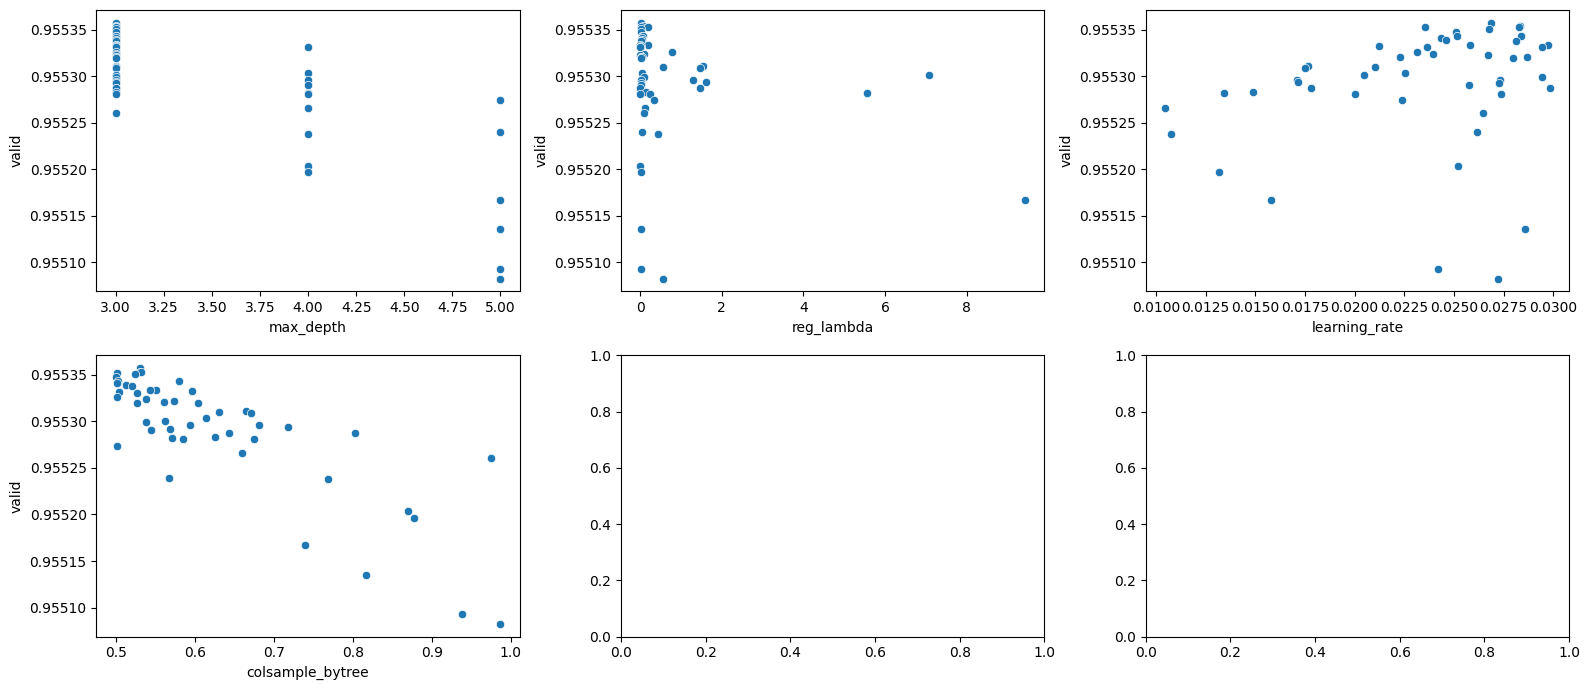

In [228]:
X_params = ['max_depth', 'reg_lambda', 'learning_rate',	'colsample_bytree']
_, axes = plt.subplots(2, 3, figsize = (16, 7))
for i, ax in zip(X_params, axes.flatten()):
    sns.scatterplot(
        df_xgb_optuna.T.reset_index(0, drop=True).T, x = i, y = 'valid', ax = ax
    )
plt.tight_layout()
plt.show()

### 분석: XGBoost Optuna scatter

- max_depth: 3이 압도적 — depth 4~5는 AUC 하락
- colsample_bytree: 0.5~0.55 구간에 최적값 집중 → 하한을 낮춰 재탐색 필요
- learning_rate: 0.02~0.03 사이가 최적 구간
- reg_lambda: 0.01~0.1 사이에서 큰 영향 없음

In [229]:
e_aml.add_collector(
    ModelAttrCollector('lgb_evals_results', Connector(processor=lgb.LGBMClassifier), 'evals_result')
)

# XGB는 GPU를 사용해서
e_aml.set_grp('lgb_optuna', parent='lgb', params={'n_estimators': 10000})
def objective(trial):
    trial_number = trial.number
    node_name = f'lgb_optuna_{trial_number}'
    e_aml.set_node(
        node_name, grp='lgb_optuna',
        edges={'X': [(None, X_all)]},
        params={
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03),
            "num_leaves": trial.suggest_int("num_leaves", 7, 31),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.25, 1.0), 
        }
    )
    e_aml.exp(node_name)
    e_aml.finalize(node_name)
    clear_output()
    return e_aml.collectors['AUC'].get_metrics_agg(node_name)[0].iloc[0]['valid']

# Study 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2026-02-24 09:24:56,291] Trial 49 finished with value: 0.9553012803537798 and parameters: {'learning_rate': 0.01625805151783346, 'num_leaves': 29, 'reg_lambda': 0.023221374039833792, 'colsample_bytree': 0.2652499788407333}. Best is trial 25 with value: 0.9553062428752077.


Best Score: 0.9553062428752077
Best Params: {'learning_rate': 0.020607186297884036, 'num_leaves': 20, 'reg_lambda': 0.004425590641361036, 'colsample_bytree': 0.26515689156693767}


## LightGBM Optuna 탐색

탐색 범위: num_leaves(10~50), learning_rate(0.01~0.05), reg_lambda(1e-3~10), colsample_bytree(0.1~1.0)

In [234]:
d = e_aml.collectors['lgb_evals_results'].get_attrs('lgb_optuna.*')
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('valid_0', 'auc')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
df_lgb_optuna =e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('lgb_optuna.*')
)['LGBMClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
        'lgb_optuna.*'
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).join(
    s_best_iteration
).sort_values(('AUC', 'valid'), ascending=False)
df_lgb_optuna.iloc[:10]

params                                           AUC  \
              colsample_bytree learning_rate num_leaves reg_lambda     valid   
lgb_optuna_25         0.265157      0.020607         20   0.004426  0.955306   
lgb_optuna_16         0.309949      0.029977         13   0.001037  0.955302   
lgb_optuna_49         0.265250      0.016258         29   0.023221  0.955301   
lgb_optuna_10         0.257306      0.021063          7   0.014671  0.955300   
lgb_optuna_4          0.381874      0.010577         15   0.001079  0.955299   
lgb_optuna_26         0.254640      0.019921         22   0.005080  0.955298   
lgb_optuna_41         0.256415      0.016966         22   0.005691  0.955295   
lgb_optuna_0          0.321682      0.027439         10   0.419266  0.955294   
lgb_optuna_21         0.349007      0.011092         14   0.001381  0.955292   
lgb_optuna_18         0.312863      0.029824         12   0.007258  0.955292   

                evals_result  
              best_iteration  
lgb_optuna_25         2366.0  
lgb_optuna_16         1904.0  
lgb_optuna_49         2549.0  
lgb_optuna_10         4645.0  
lgb_optuna_4          4048.0  
lgb_optuna_26         2186.0  
lgb_optuna_41         2545.0  
lgb_optuna_0          2361.0  
lgb_optuna_21         3818.0  
lgb_optuna_18         1882.0

### 분석: LightGBM Optuna 결과

| Best 파라미터 | 값 |
|---|---|
| learning_rate | 0.021 |
| num_leaves | 20 |
| reg_lambda | 0.004 |
| colsample_bytree | 0.265 |
| best valid AUC | **0.955306** |

- num_leaves=20은 depth=3~4에 상당, 트리 모델 공통으로 얕은 tree가 유리
- colsample_bytree가 CB rsm과 유사하게 0.25~0.31 저수준에서 최적
- XGB(0.9554) > LGB(0.9553) 미세 차이 — 최종 파라미터로 확정

- XGB의 colsample_bytree의 하한선은 너무 높게 잡은 듯하여, 하한선을 낮추어 실험을 구성 ('max_depth': 3)

In [235]:
e_aml.set_grp('xgb_optuna2', parent='xgb', params={'n_estimators': 10000, 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 3})
def objective(trial):
    trial_number = trial.number
    node_name = f'xgb_optun2a_{trial_number}'
    e_aml.set_node(
        node_name, grp='xgb_optuna2',
        edges={'X': [(None, X_all)]},
        params={
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.25, 0.75), 
        }
    )
    e_aml.exp(node_name)
    e_aml.finalize(node_name)
    clear_output()
    return e_aml.collectors['AUC'].get_metrics_agg(node_name)[0].iloc[0]['valid']

# Study 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2026-02-24 09:35:51,432] Trial 49 finished with value: 0.9553754363816049 and parameters: {'learning_rate': 0.01578776719819734, 'reg_lambda': 0.004487310407416835, 'colsample_bytree': 0.349221344981771}. Best is trial 13 with value: 0.9553767977260723.


Best Score: 0.9553767977260723
Best Params: {'learning_rate': 0.01825416966680926, 'reg_lambda': 0.007033391681411446, 'colsample_bytree': 0.35062791656003417}


In [236]:
d = e_aml.collectors['xgb_evals_results'].get_attrs('xgb_optun2a.*')
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('validation_0', 'auc')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
df_xgb_optuna =e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('xgb_optun2a.*')
)['XGBClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
        'xgb_optun2a.*'
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).join(
    s_best_iteration
).sort_values(('AUC', 'valid'), ascending=False)
df_xgb_optuna.iloc[:10]

params                                AUC  \
               colsample_bytree learning_rate reg_lambda     valid   
xgb_optun2a_13         0.350628      0.018254   0.007033  0.955377   
xgb_optun2a_9          0.382289      0.019680   0.001721  0.955376   
xgb_optun2a_49         0.349221      0.015788   0.004487  0.955375   
xgb_optun2a_45         0.369971      0.019972   0.001740  0.955375   
xgb_optun2a_26         0.358798      0.023905   0.003608  0.955371   
xgb_optun2a_11         0.406340      0.020946   0.007659  0.955370   
xgb_optun2a_42         0.250061      0.023700   0.001069  0.955370   
xgb_optun2a_40         0.332319      0.022305   0.001057  0.955370   
xgb_optun2a_48         0.412466      0.020077   0.001806  0.955369   
xgb_optun2a_12         0.362170      0.019553   0.006012  0.955366   

                 evals_result  
               best_iteration  
xgb_optun2a_13         5103.0  
xgb_optun2a_9          4572.0  
xgb_optun2a_49         5680.0  
xgb_optun2a_45         4412.0  
xgb_optun2a_26         3459.0  
xgb_optun2a_11         4180.0  
xgb_optun2a_42         5004.0  
xgb_optun2a_40         4013.0  
xgb_optun2a_48         4630.0  
xgb_optun2a_12         4499.0

### 분석: XGBoost Optuna2 (colsample 하한 확대)

| 노드 | colsample_bytree | learning_rate | AUC |
|------|-----------------|--------------|-----|
| xgb_optun2a_13 (best) | 0.351 | 0.018 | **0.955377** |
| xgb_optun2a_9 | 0.382 | 0.020 | 0.955376 |

- colsample 하한을 0.5→0.1로 낮춰도 최적값은 0.35 수준에 수렴
- XGB 최종 파라미터: max_depth=3, lr≈0.018, reg_lambda≈0.007, colsample≈0.35

## CatBoost Optuna 재탐색 (high lr 구간)

`cb_optuna2` 결과에서 최적 lr=0.042로 1차 탐색 상한(0.015)을 크게 초과.
높은 lr 구간(0.03~0.2)에서 rsm과의 조합 재탐색. depth=3, l2_leaf_reg=1.5 고정.

In [246]:
def objective(trial):
    trial_number = trial.number
    node_name = f'cb_optuna3_{trial_number}'
    e_aml.set_node(
        node_name, grp='cb_optuna2',
        edges={'X': [(None, X_all)]},
        params={
            "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.2),
            "rsm": trial.suggest_float("rsm", 0.25, 1.0), 
        }
    )
    e_aml.exp(node_name)
    e_aml.finalize(node_name)
    clear_output()
    return e_aml.collectors['AUC'].get_metrics_agg(node_name)[0].iloc[0]['valid']

# Study 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2026-02-24 09:52:01,608] Trial 19 finished with value: 0.9553203168926013 and parameters: {'learning_rate': 0.07517509655120061, 'rsm': 0.8023958790777355}. Best is trial 11 with value: 0.9553572838062382.


Best Score: 0.9553572838062382
Best Params: {'learning_rate': 0.12146937969142849, 'rsm': 0.9784832693721128}


In [249]:
d = e_aml.collectors['cb_evals_results'].get_attrs('cb_.*')
s_best_iteration = pd.Series({
    k: np.mean(
        [[j.unstack().unstack()[('validation', 'AUC')].argmax() for j in i] for i in v]
    )
    for k, v in d.items()
}, name=('evals_result', 'best_iteration'))
df_cb_optuna2 =e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('cb_.*')
)['CatBoostClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
        'cb_.*'
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).join(
    s_best_iteration
).sort_values(('AUC', 'valid'), ascending=False)
df_cb_optuna2.iloc[:10]

params                                            \
                    border_count depth l2_leaf_reg learning_rate max_depth   
cb_optuna3_11                NaN   NaN         NaN      0.121469       3.0   
cb_rsm_0.75                  NaN   3.0         NaN      0.050000       NaN   
cb_border_count_511        511.0   3.0         NaN      0.050000       NaN   
cb_optuna3_9                 NaN   NaN         NaN      0.102742       3.0   
cb_optuna3_7                 NaN   NaN         NaN      0.097888       3.0   
cb_optuna3_6                 NaN   NaN         NaN      0.058160       3.0   
cb_optuna3_8                 NaN   NaN         NaN      0.156202       3.0   
cb_optuna3_12                NaN   NaN         NaN      0.128234       3.0   
cb_optuna2_4                 NaN   NaN         NaN      0.042117       3.0   
cb_optuna3_13                NaN   NaN         NaN      0.112958       3.0   

                                              AUC   evals_result  
                          rsm subsample     valid best_iteration  
cb_optuna3_11        0.978483       NaN  0.955357         1248.0  
cb_rsm_0.75          0.750000       NaN  0.955354         3175.0  
cb_border_count_511  0.750000       NaN  0.955354            NaN  
cb_optuna3_9         0.723387       NaN  0.955350         1520.0  
cb_optuna3_7         0.989288       NaN  0.955344         1319.0  
cb_optuna3_6         0.995987       NaN  0.955344         2376.0  
cb_optuna3_8         0.731636       NaN  0.955340         1007.0  
cb_optuna3_12        0.790169       NaN  0.955339         1211.0  
cb_optuna2_4         0.813875       NaN  0.955338         3134.0  
cb_optuna3_13        0.871323       NaN  0.955338         1122.0

### Experment Result

In [271]:
e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('.*')
)['LGBMClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).sort_values(('AUC', 'valid'), ascending=False).iloc[:10]

params                                              \
              categorical_feature colsample_bytree learning_rate n_estimators   
lgb_optuna_25                None         0.265157      0.020607        10000   
lgb_optuna_16                None         0.309949      0.029977        10000   
lgb_optuna_49                None         0.265250      0.016258        10000   
lgb_optuna_10                None         0.257306      0.021063        10000   
lgb_optuna_4                 None         0.381874      0.010577        10000   
lgb_optuna_26                None         0.254640      0.019921        10000   
lgb_optuna_41                None         0.256415      0.016966        10000   
lgb_optuna_0                 None         0.321682      0.027439        10000   
lgb_optuna_21                None         0.349007      0.011092        10000   
lgb_optuna_18                None         0.312863      0.029824        10000   

                                          AUC  
              num_leaves reg_lambda     valid  
lgb_optuna_25       20.0   0.004426  0.955306  
lgb_optuna_16       13.0   0.001037  0.955302  
lgb_optuna_49       29.0   0.023221  0.955301  
lgb_optuna_10        7.0   0.014671  0.955300  
lgb_optuna_4        15.0   0.001079  0.955299  
lgb_optuna_26       22.0   0.005080  0.955298  
lgb_optuna_41       22.0   0.005691  0.955295  
lgb_optuna_0        10.0   0.419266  0.955294  
lgb_optuna_21       14.0   0.001381  0.955292  
lgb_optuna_18       12.0   0.007258  0.955292

In [245]:
e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('.*')
)['XGBClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).sort_values(('AUC', 'valid'), ascending=False).iloc[:10]

params                                              \
               colsample_bytree device learning_rate max_depth n_estimators   
xgb_optun2a_13         0.350628   cuda      0.018254       3.0        10000   
xgb_optun2a_9          0.382289   cuda      0.019680       3.0        10000   
xgb_optun2a_49         0.349221   cuda      0.015788       3.0        10000   
xgb_optun2a_45         0.369971   cuda      0.019972       3.0        10000   
xgb_optun2a_26         0.358798   cuda      0.023905       3.0        10000   
xgb_optun2a_11         0.406340   cuda      0.020946       3.0        10000   
xgb_optun2a_42         0.250061   cuda      0.023700       3.0        10000   
xgb_optun2a_40         0.332319   cuda      0.022305       3.0        10000   
xgb_optun2a_48         0.412466   cuda      0.020077       3.0        10000   
xgb_optun2a_12         0.362170   cuda      0.019553       3.0        10000   

                                            AUC  
               reg_lambda tree_method     valid  
xgb_optun2a_13   0.007033        hist  0.955377  
xgb_optun2a_9    0.001721        hist  0.955376  
xgb_optun2a_49   0.004487        hist  0.955375  
xgb_optun2a_45   0.001740        hist  0.955375  
xgb_optun2a_26   0.003608        hist  0.955371  
xgb_optun2a_11   0.007659        hist  0.955370  
xgb_optun2a_42   0.001069        hist  0.955370  
xgb_optun2a_40   0.001057        hist  0.955370  
xgb_optun2a_48   0.001806        hist  0.955369  
xgb_optun2a_12   0.006012        hist  0.955366

In [244]:
e_aml.pipeline.compare_nodes(
    e_aml.pipeline.get_node_names('.*')
)['CatBoostClassifier'].join(
    e_aml.collectors['AUC'].get_metrics_agg(
    )[0][['valid']].stack().rename('AUC').to_frame().unstack()
).sort_values(('AUC', 'valid'), ascending=False).iloc[:10]

params                                            \
                    border_count cat_features depth iterations l2_leaf_reg   
cb_border_count_511        511.0         None   3.0      10000         NaN   
cb_rsm_0.75                  NaN         None   3.0      10000         NaN   
cb_optuna2_4                 NaN         None   NaN      10000         NaN   
cb_optuna2_2                 NaN         None   NaN      10000         NaN   
cb_optuna2_12                NaN         None   NaN      10000         NaN   
cb_subsample_0.5             NaN         None   3.0      10000         NaN   
cb_optuna2_8                 NaN         None   NaN      10000         NaN   
cb_optuna2_19                NaN         None   NaN      10000         NaN   
cb_max_depth_3               NaN         None   3.0      10000         NaN   
cb_optuna2_1                 NaN         None   NaN      10000         NaN   

                                                                         \
                    learning_rate max_depth       rsm subsample verbose   
cb_border_count_511      0.050000       NaN  0.750000       NaN       0   
cb_rsm_0.75              0.050000       NaN  0.750000       NaN       0   
cb_optuna2_4             0.042117       3.0  0.813875       NaN       0   
cb_optuna2_2             0.020167       3.0  0.582808       NaN       0   
cb_optuna2_12            0.019405       3.0  0.665371       NaN       0   
cb_subsample_0.5         0.050000       NaN       NaN       0.5       0   
cb_optuna2_8             0.039595       3.0  0.957362       NaN       0   
cb_optuna2_19            0.028572       3.0  0.725664       NaN       0   
cb_max_depth_3           0.050000       NaN       NaN       NaN       0   
cb_optuna2_1             0.023846       3.0  0.760800       NaN       0   

                                                                                                               X  \
                    DataSource [Age, BP, Cholesterol, Exercise angina, FBS over 120, Max HR, ST depression, Sex]   
cb_border_count_511  [Chest pain type, EKG results, Number of vesse...                                             
cb_rsm_0.75          [Chest pain type, EKG results, Number of vesse...                                             
cb_optuna2_4         [Chest pain type, EKG results, Number of vesse...                                             
cb_optuna2_2         [Chest pain type, EKG results, Number of vesse...                                             
cb_optuna2_12        [Chest pain type, EKG results, Number of vesse...                                             
cb_subsample_0.5     [Chest pain type, EKG results, Number of vesse...                                             
cb_optuna2_8         [Chest pain type, EKG results, Number of vesse...                                             
cb_optuna2_19        [Chest pain type, EKG results, Number of vesse...                                             
cb_max_depth_3       [Chest pain type, EKG results, Number of vesse...                                             
cb_optuna2_1         [Chest pain type, EKG results, Number of vesse...                                             

                          AUC  
                        valid  
cb_border_count_511  0.955354  
cb_rsm_0.75          0.955354  
cb_optuna2_4         0.955338  
cb_optuna2_2         0.955336  
cb_optuna2_12        0.955335  
cb_subsample_0.5     0.955334  
cb_optuna2_8         0.955333  
cb_optuna2_19        0.955332  
cb_max_depth_3       0.955331  
cb_optuna2_1         0.955329

In [250]:
e_aml.close_exp()

Finalize 'lbl'
Finalize 'ohe'
Finalize 'std'
Finalize 'n2c'
Finalize 'lgb1'
Finalize 'lr1'
Finalize 'cb1'
Finalize 'xgb1'
Finalize 'cont_inter'
Finalize 'freq_st'
Finalize 'cat_pair'
Finalize 'xgb_all_fe'
Finalize 'xgb_cat'
Finalize 'xgb_cont'
Finalize 'xgb_freq'
Finalize 'lgb_cat'
Finalize 'lgb_all_fe'
Finalize 'cb2'
Finalize 'ohe_pair'
Finalize 'lr2'
Finalize 'std_cont_inter'
Finalize 'lr3'
Finalize 'te_pair'
Finalize 'lr4'
Finalize 'lr5'
Finalize 'lr6'
Finalize 'cb_optuna_33'
Finalize 'cb3'
Finalize 'cb4'
Finalize 'cb_rsm_0.75'


# Modeling

**모델 구성 기준:**
- HP 튜닝 결과를 반영한 최종 파라미터로 xgb1, lgb1, cb1 재구성
- StratifiedKFold(5) 적용 — target 불균형(55:45) 대응
- StackingCollector 추가 → OOF 예측값 수집, stacking 실험용
- lr2(선형)도 앙상블 다양성을 위해 포함 (FE 분석에서 best LR 모델)

In [13]:
from sklearn.model_selection import StratifiedKFold
if os.path.exists('exp/modeling'):
    e_modeling = Experimenter.load('exp/modeling', df_train)
    if e_modeling.status == 'closed':
        e_modeling.reopen_exp()
else:
    e_modeling = Experimenter.create(
        df_train, 'exp/modeling', title='모델링을 ML 실험',
        sp=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
        splitter_params={'y': target}
    )
Markdown(
    e_modeling.desc_spec()
)

e_modeling.set_grp('pre', role='stage', method='transform')
e_modeling.set_node(
    'lbl', grp='pre', processor=LabelEncoder,
    edges={'y': [(None, target)]}
)
e_modeling.build()
e_modeling.set_grp(
    'clf', role='head', method='predict_proba',
    edges={'y': [('lbl', None)]}
)
# XGBoost
e_modeling.set_grp('xgb', parent='clf', processor=xgb.XGBClassifier,
    adapter=XGBoostAdapter(eval_mode='valid'),
    params={
        'tree_method': 'hist', 'device': 'cuda',
        'enable_categorical': True,
        'verbosity': 0,
        'random_state': 1,
    }
)

# LightGBM
e_modeling.set_grp('lgb', parent='clf', processor=lgb.LGBMClassifier,
    adapter=LightGBMAdapter(eval_mode='valid'),
    params={
        'verbose': -1,
        'random_state': 1,
    }
)

# CatBoost
e_modeling.set_grp('cb', parent='clf', processor=cb.CatBoostClassifier,
    adapter=CatBoostAdapter(eval_mode='valid'),
    params={
        'verbose': 0,
        'random_state': 1,
    }
)

# LogisticRegression (coef 분석용)
e_modeling.set_grp('lr', parent='clf', processor=LogisticRegression,
    params={
        'max_iter': 1000,
        'random_state': 1,
    }
)

Loaded: 10 node(s), 6 group(s), 5 fold(s)
Building 0 node(s)
Build 5/5 (100%)> Node 0
Build complete: 0 node(s)


{'result': 'skip',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f7f1a8c5cd0>,
 'affected_nodes': []}

In [14]:
from mllabs.collector import StackingCollector
e_modeling.add_collector(
    MetricCollector(
        'AUC',
        Connector(edges={'y': [('lbl', None)]}),
        slice(-1, None),
        roc_auc_score,
        include_train = True
    )
)

e_modeling.add_collector(
    StackingCollector(
        'stacking', Connector(edges={'y': [('lbl', None)]}),
        slice(-1, None), method='mean', experimenter = e_modeling
    )
)

e_modeling.set_node(
    'ohe', grp='pre', processor=OneHotEncoder,
    edges={'X': [(None, X_nom + X_ord)]},
    params={'sparse_output': False}
)

e_modeling.set_node(
    'std', grp='pre', processor=StandardScaler,
    edges={'X': [(None, X_cont)]}
)

e_modeling.set_node(
    'cat_pair', grp='pre', processor=CatPairCombiner,
    edges={'X': [(None, X_nom + X_bin)]},
    params={
        'pairs': [
            ('Thallium', 'Chest pain type'),
            ('Chest pain type', 'Exercise angina'),
            ('Thallium', 'Exercise angina'),
        ]
    }
)

e_modeling.set_node(
    'cont_inter', grp='pre', processor=PolynomialFeatures,
    edges={'X': [(None, ['Age', 'Cholesterol', 'Max HR'])]},
    params={'degree': 2, 'include_bias': False, 'interaction_only': True}
)
e_modeling.set_node('ohe_pair', processor = OneHotEncoder, grp='pre', edges={'X': [('cat_pair', None)]}, params={'sparse_output': False})

{'result': 'skip',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f7f1a8c5310>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f7f1a8c5310>}

In [15]:
e_modeling.set_node(
    'xgb1', grp='xgb', edges={'X': [(None, X_all)]}, 
    params = {'colsample_bytree': 0.35, 'learning_rate': 0.018254, 'max_depth': 3,  'reg_lambda': 0.007033, 'n_estimators': 5100}
)
e_modeling.set_node(
    'cb1', grp='cb', edges={'X': [(None, X_all)]},
    params = {'max_depth': 3, 'learning_rate': 0.042117, 'rsm': 0.75, 'n_estimators': 3200}
)
e_modeling.set_node(
    'lgb1', grp='lgb', edges={'X': [(None, X_all)]},
    params = {'colsample_bytree': 0.265157, 'learning_rate': 0.020607, 'num_leaves': 20, 'reg_lambda': 0.004426, 'n_estimators': 2400}
)
e_modeling.exp()

Experimenting 0 node(s)
Exp 5/5 (100%)> Node 0
Experimentation complete: 0 node(s)


In [16]:
e_modeling.set_node(
    'lr2', grp='lr', edges = {'X': [('std', None), (None, X_bin), ('ohe', ohe_drop_first), ('ohe_pair', ohe_drop_first)]}, 
)
e_modeling.build()
e_modeling.exp()

Building 0 node(s)
Build 5/5 (100%)> Node 0
Build complete: 0 node(s)
Experimenting 0 node(s)
Exp 5/5 (100%)> Node 0
Experimentation complete: 0 node(s)


In [17]:
e_modeling.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending = False)

,valid,train_sub
xgb1,0.955628,0.956272
lgb1,0.955590,0.956647
cb1,0.955554,0.956179
lr2,0.952929,0.952947


### 분석: 최종 모델 성능

| 모델 | valid AUC |
|------|----------|
| xgb1 (HP 튜닝 적용) | **0.955628** |
| lgb1 (HP 튜닝 적용) | 0.955590 |
| cb1 (HP 튜닝 적용) | 0.955554 |
| lr2 | 0.952929 |

- HP 튜닝 후 모든 트리 모델이 e_aml 대비 소폭 상승 (0.9549→0.9556)
- xgb1이 근소하게 1위, 세 트리 모델이 거의 동급
- lr2는 다양성 목적으로 stacking에 포함 (단독 성능은 하위)

In [18]:
e_modeling.add_trainer('trainer')

# Stacking

`StackingCollector`가 CV 과정에서 각 fold의 out-of-fold 예측값을 수집.
valid fold 예측값을 train index에 맞춰 재조합하면 leakage 없는 stacking 피처 생성.
이를 새 Experimenter(`e_stacking`)의 입력으로 활용하여 앙상블 조합 탐색.

In [19]:
df_stacking = e_modeling.collectors['stacking'].get_dataset().sort_index()
df_stacking.head()

,xgb1__Heart Disease_1,lgb1__Heart Disease_1,lr2__Heart Disease_1,cb1__Heart Disease_1,Heart Disease
id,,,,,
0,0.997452,0.997422,0.997146,0.997866,1
1,0.009248,0.009643,0.015919,0.008130,0
2,0.009843,0.010390,0.017949,0.009044,0
3,0.049203,0.057194,0.051042,0.049295,0
4,0.997664,0.997301,0.997770,0.998165,1


In [20]:
if os.path.exists('exp/stacking'):
    e_stacking = Experimenter.load('exp/stacking', df_stacking)
    if e_stacking.status == 'closed':
        e_stacking.reopen_exp()
else:
    e_stacking = Experimenter.create(
        df_stacking, 'exp/stacking', title='Stacking을 ML 실험',
        sp=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
        splitter_params={'y': target}
    )

e_stacking.add_collector(
    MetricCollector(
        'AUC',
        Connector(edges={'y': [(None, target)]}),
        slice(-1, None),
        roc_auc_score,
        include_train = True
    )
)

e_stacking.set_grp('pre', role='stage', method='transform')
e_stacking.build()
e_stacking.set_grp(
    'clf', role='head', method='predict_proba',
    edges={'y': [(None, target)]}
)

Loaded: 4 node(s), 2 group(s), 5 fold(s)
Building 0 node(s)
Build 5/5 (100%)> Node 0
Build complete: 0 node(s)


{'result': 'skip',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f7f19d17ef0>,
 'affected_nodes': []}

In [21]:
X_stk = [i for i in df_stacking.columns if i != target]
X_stk

['xgb1__Heart Disease_1',
 'lgb1__Heart Disease_1',
 'lr2__Heart Disease_1',
 'cb1__Heart Disease_1']

In [22]:
e_stacking.set_node('lr', processor=LogisticRegression, grp='clf', edges={'X': [(None, X_stk)]})
e_stacking.exp()

Experimenting 0 node(s)
Exp 5/5 (100%)> Node 0
Experimentation complete: 0 node(s)


In [23]:
e_stacking.set_node('lr2', processor=LogisticRegression, grp='clf', edges={'X': [(None, ['xgb1__Heart Disease_1','lgb1__Heart Disease_1'])]})
e_stacking.exp()

Experimenting 0 node(s)
Exp 5/5 (100%)> Node 0
Experimentation complete: 0 node(s)


In [24]:
e_stacking.collectors['AUC'].get_metrics_agg()[0]

,valid,train_sub
lr,0.955622,0.955618
lr2,0.955630,0.955626
lr3,0.955626,0.955622
lr4,0.955620,0.955617


In [25]:
e_stacking.set_node('lr3', processor=LogisticRegression, grp='clf', edges={'X': [(None, ['xgb1__Heart Disease_1','lgb1__Heart Disease_1','cb1__Heart Disease_1'])]})
e_stacking.exp()

Experimenting 0 node(s)
Exp 5/5 (100%)> Node 0
Experimentation complete: 0 node(s)


In [26]:
e_stacking.collectors['AUC'].get_metrics_agg()[0]

,valid,train_sub
lr,0.955622,0.955618
lr2,0.955630,0.955626
lr3,0.955626,0.955622
lr4,0.955620,0.955617


In [27]:
e_stacking.set_node('lr4', processor=LogisticRegression, grp='clf', edges={'X': [(None, ['xgb1__Heart Disease_1','lgb1__Heart Disease_1','lr2__Heart Disease_1'])]})
e_stacking.exp()

Experimenting 0 node(s)
Exp 5/5 (100%)> Node 0
Experimentation complete: 0 node(s)


In [38]:
e_stacking.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending=False)

,valid,train_sub
lr2,0.955630,0.955626
lr3,0.955626,0.955622
lr,0.955622,0.955618
lr4,0.955620,0.955617


### 분석: Stacking 앙상블 결론

| 조합 | valid AUC |
|------|----------|
| lr2 (xgb+lgb) | **0.955630** |
| lr3 (xgb+lgb+cb) | 0.955626 |
| lr (전체 4모델) | 0.955622 |
| lr4 (xgb+lgb+lr2) | 0.955620 |

- xgb+lgb 조합(lr2)이 cb, lr2 추가 시보다 미세하게 우위
- cb1은 이미 유사한 패턴을 학습해 다양성 기여가 낮음
- lr2(선형 모델)는 트리와 이미 다른 패턴이지만 스태킹 레벨에서 노이즈로 작용
- 스태킹 자체 개선폭(0.9556→0.9556)이 미미 — 단일 최고 모델과 사실상 동급

In [41]:
e_stacking.add_trainer('trainer')
e_stacking.trainers['trainer'].select_head(['lr2'])
e_stacking.trainers['trainer'].train()

lr2 1/1 (100%) Split 1/1 (100%)
Train complete: 1 node(s)


In [30]:
e_modeling.add_trainer('trainer')
e_modeling.trainers['trainer'].select_head(['xgb1', 'lgb1'])
e_modeling.trainers['trainer'].train()

Train 0
Train complete: 0 node(s)


In [54]:
next(e_modeling.trainers['trainer'].process(df_test, slice(-1, None))).data

,xgb1__Heart Disease_1,lgb1__Heart Disease_1
id,,
630000,0.949196,0.937161
630001,0.009064,0.009210
630002,0.989547,0.989905
630003,0.004408,0.004102
630004,0.197181,0.186887
...,...,...
899995,0.152214,0.150060
899996,0.687932,0.673724
899997,0.047882,0.048240


### Inference 파이프라인

`e_modeling.trainers['trainer'].process(df_test)`로 test 데이터에 xgb1, lgb1 예측값 생성 →
`e_stacking.trainers['trainer'].process(...)`로 stacking lr2 통과 → 최종 확률값 산출.
두 Trainer가 체이닝되어 end-to-end inference를 구성.

In [45]:
df_result = next(e_stacking.trainers['trainer'].process(
    next(e_modeling.trainers['trainer'].process(df_test, slice(-1, None))).data, slice(-1, None)
)).data

In [49]:
df_result.iloc[:, -1].rename(target).to_csv('data/submission0.csv')

In [ ]:
# !kaggle competitions submit -c playground-series-s6e2 -f data/submission0.csv -m "Test"